In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Part 1: London’s underground resilience

## I. Topological network

#### Preprocessing

In [3]:
# Create an undirected graph of the London Underground.
G = nx.read_graphml('london_updated.graphml')

In [4]:
# Since coords tuples are stored as string, need to convert them back to tuples using eval().
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [5]:
# To check node attributes.
list(G.nodes(data = True))[0]

('Stratford', {'coords': (538524.7855297636, 184373.34100822973)})

In [6]:
# To check edges attributes.
list(G.edges(data = True))[0]

('Stratford',
 'Stratford High Street',
 {'length': 519.300073543952, 'line_name': 'DLR', 'flows': 1089})

In [7]:
# Check the data.
df_1 = nx.to_pandas_edgelist(G)
df_1[0:10]

source                   target          line_name  \
0              Stratford    Stratford High Street                DLR   
1              Stratford        Pudding Mill Lane                DLR   
2              Stratford  Stratford International                DLR   
3              Stratford                 Mile End            Central   
4              Stratford                   Leyton            Central   
5              Stratford         Liverpool Street           TfL Rail   
6              Stratford                 Maryland           TfL Rail   
7              Stratford             Hackney Wick  London Overground   
8              Stratford                 West Ham            Jubilee   
9  Stratford High Street               Abbey Road                DLR   

        length   flows  
0   519.300074    1089  
1  1137.033257    4261  
2  1321.068117    3833  
3  2805.001392   11885  
4  2131.342926   56082  
5  6698.461270  155724  
6   951.304721   34442  
7  1572.923279    7798  
8  1673.509515   91357  
9   655.211301    1206

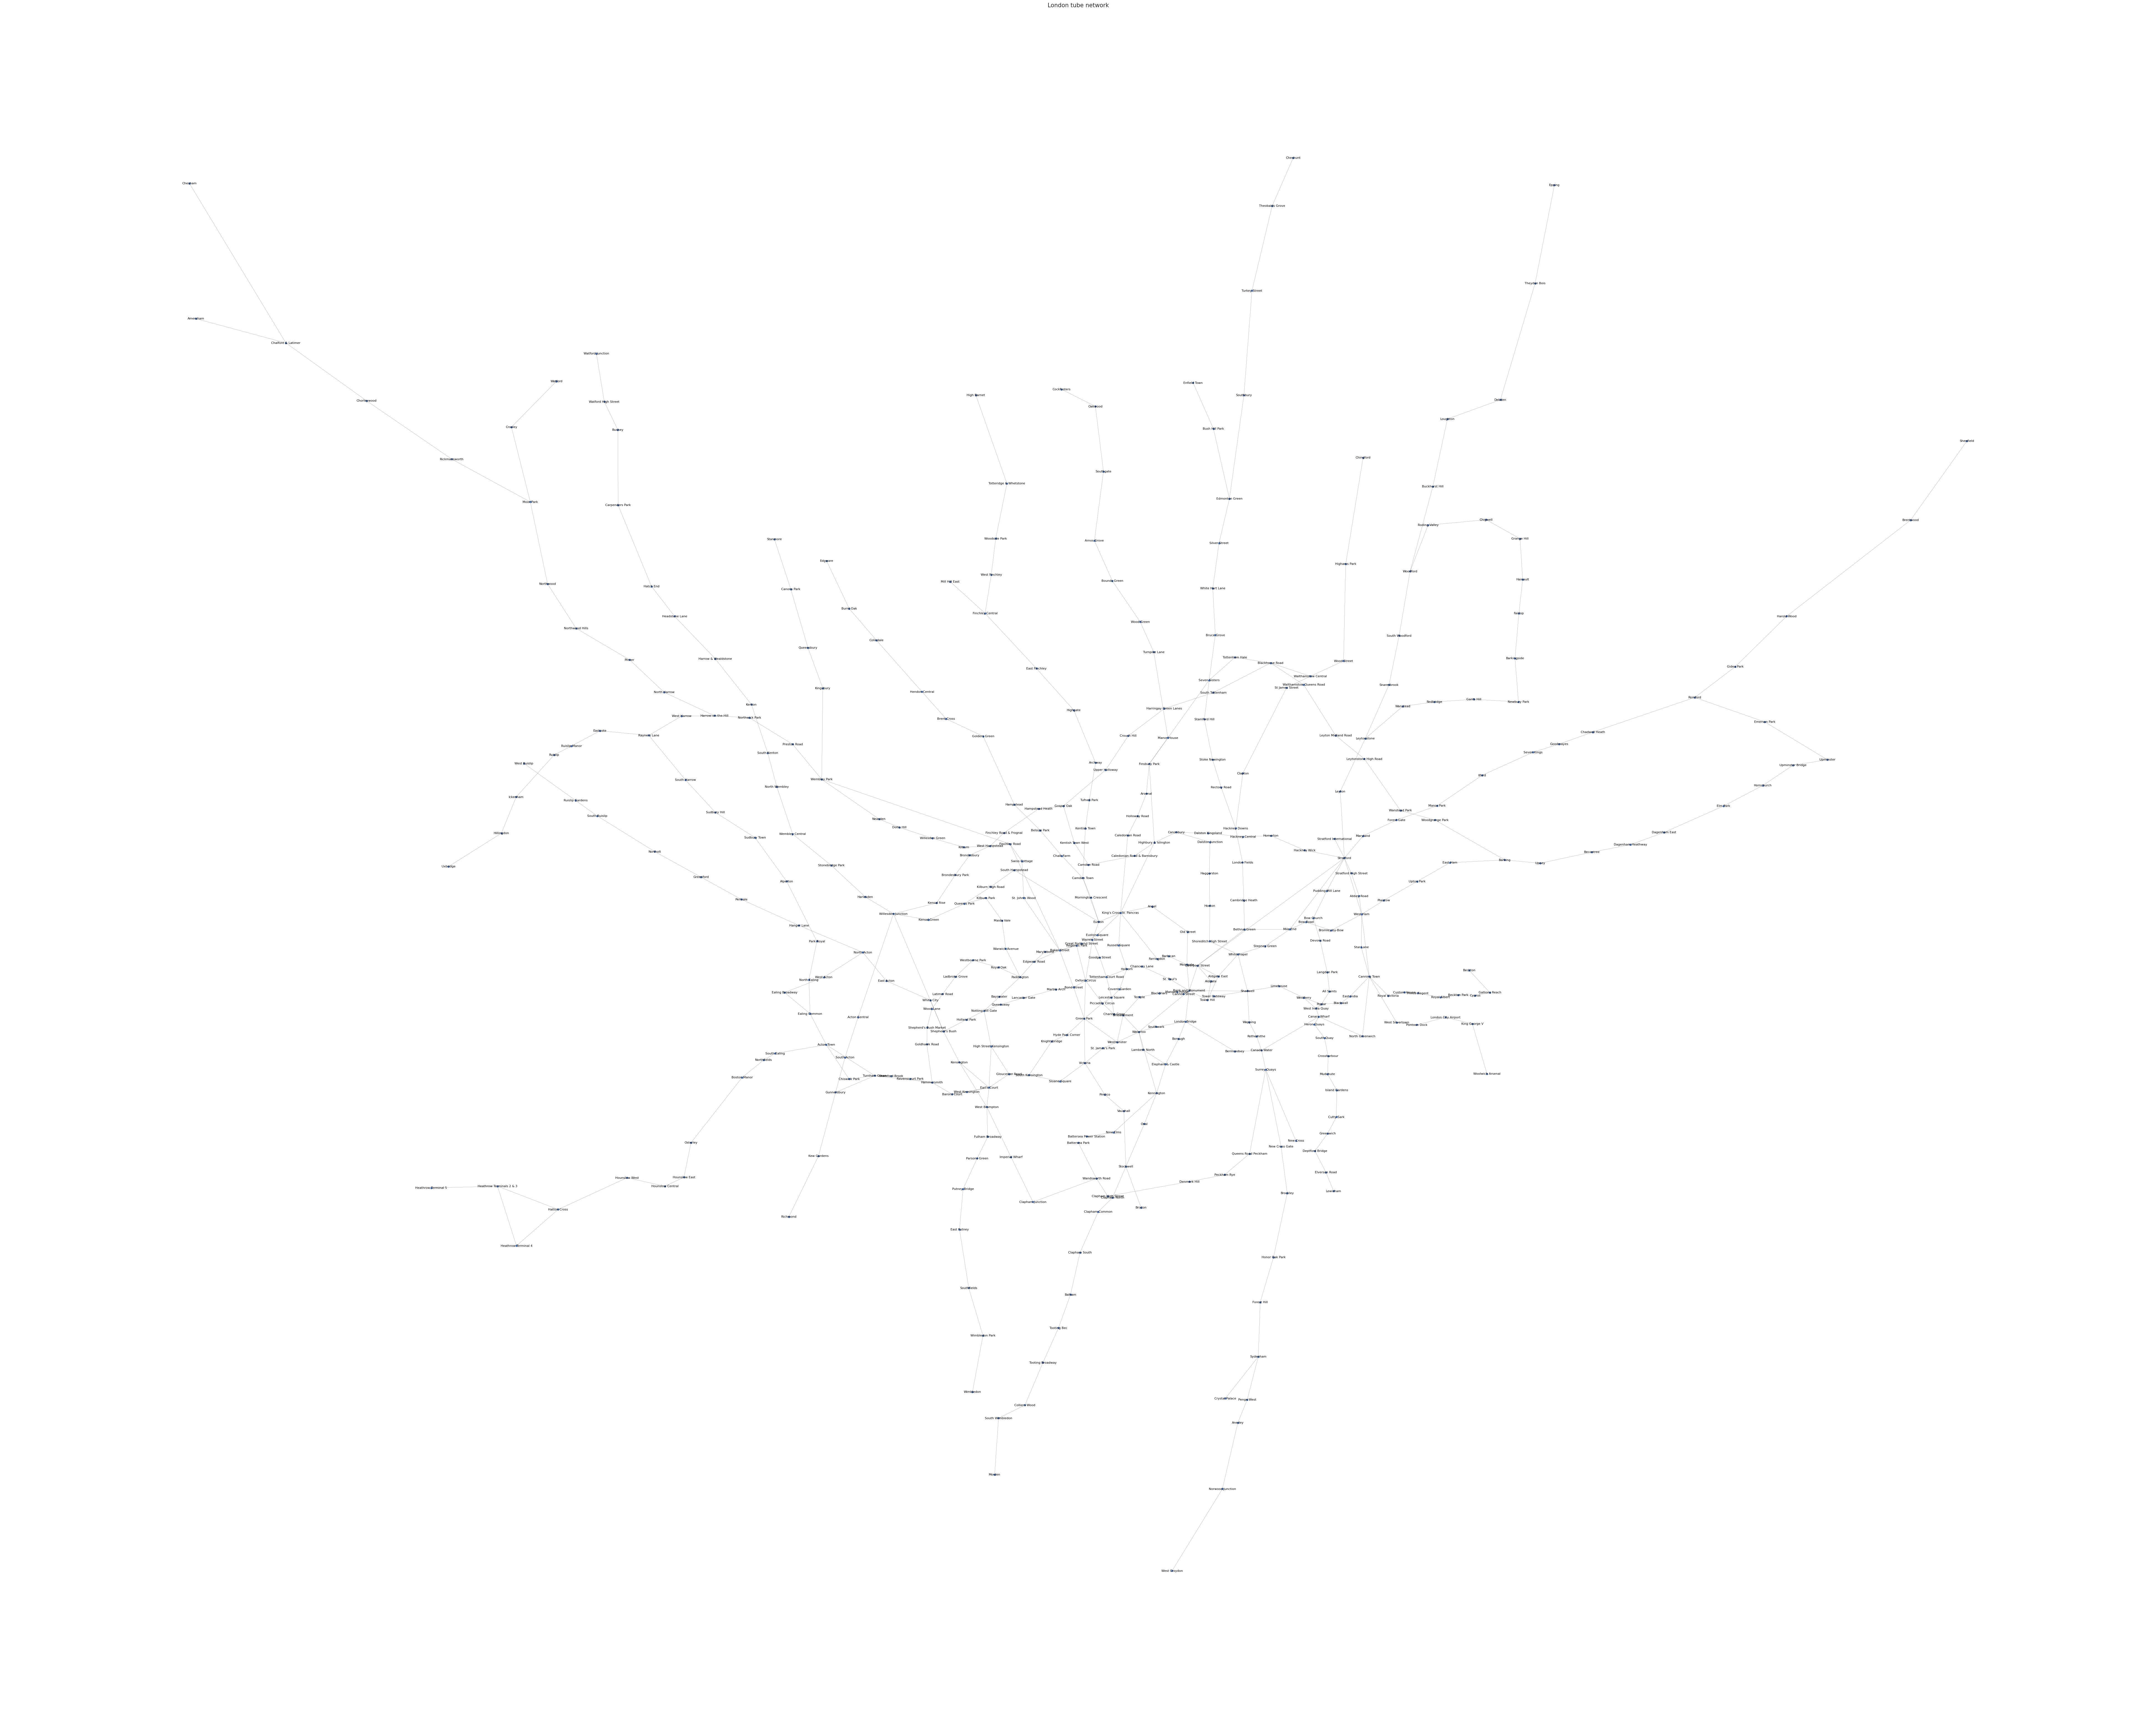

In [123]:
# Plot the tube network with the names of the stations as labels.
fig, ax = plt.subplots(figsize=(100, 80))

node_labels = {node: node for node in G.nodes()}

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G, pos, node_size=20, node_color='b')
nx.draw_networkx_edges(G, pos, arrows=False, width=0.2)
nx.draw_networkx_labels(G, pos, node_labels, font_size=8, font_color='black')

plt.title("London tube network", fontsize=15)
plt.axis("off")
plt.show()

### I.1. Centrality measures

#### Betweenness Centrality

In [9]:
# Calculate the betweenness centrality.
bet_london = nx.betweenness_centrality(G)
nx.set_node_attributes(G,bet_london,'betweenness')

In [10]:
# Add betweenness centrality to dataframe.
df = pd.DataFrame(index=G.nodes())
df['betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness'))

df_sorted = df.sort_values(["betweenness"], ascending=False)
df_sorted[0:10]

betweenness
Stratford                    0.297846
Bank and Monument            0.290489
Liverpool Street             0.270807
King's Cross St. Pancras     0.255307
Waterloo                     0.243921
Green Park                   0.215835
Euston                       0.208324
Westminster                  0.203335
Baker Street                 0.191568
Finchley Road                0.165085

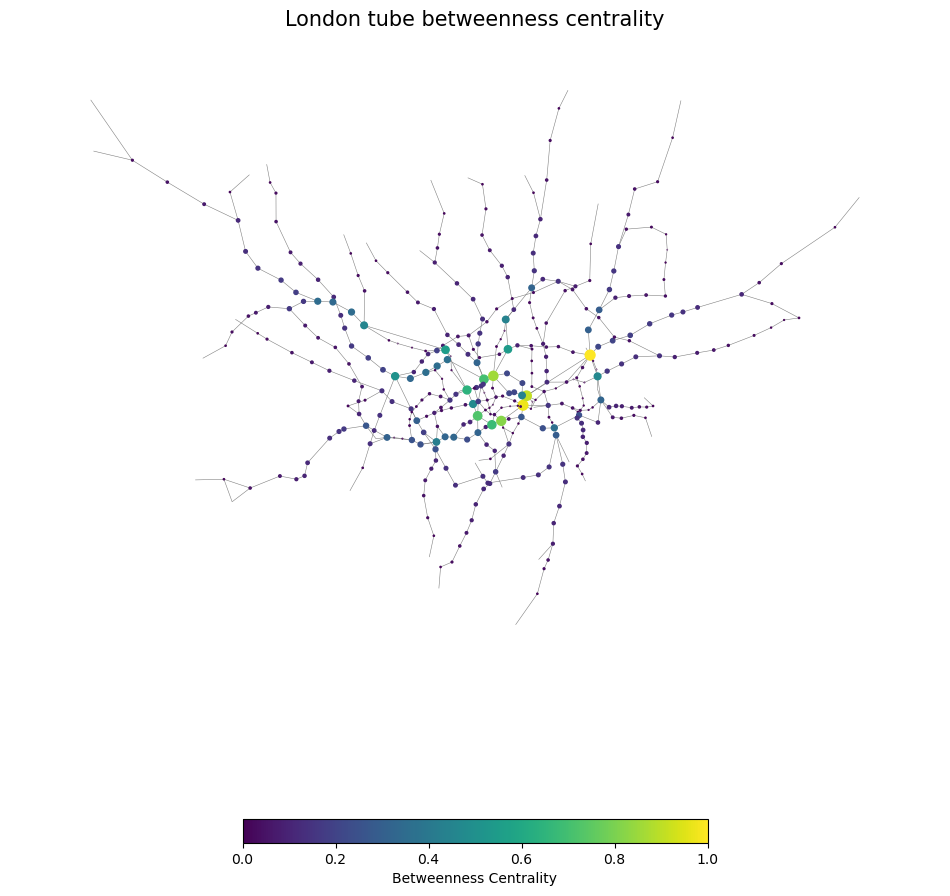

In [11]:
# Set colour and size of nodes according to betweenness values.
betweenness_values = [(i[1]['betweenness']) for i in G.nodes(data=True)]
bet_color = [(i[1]['betweenness']/max(betweenness_values)) for i in G.nodes(data=True)]
bet_size = [(i[1]['betweenness']/max(betweenness_values))*50 for i in G.nodes(data=True)]

# Plot graph.
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, 
                       pos=pos, 
                       edge_color='gray', 
                       width=0.4)

nod=nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_color=bet_color, 
                           cmap=plt.cm.viridis, 
                           node_size=bet_size)

plt.colorbar(nod, label="Betweenness Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality", fontsize=15)
plt.show()

#### Closeness Centrality

In [12]:
# Calculate the closeness centrality.
clo_london = nx.closeness_centrality(G)
nx.set_node_attributes(G, clo_london, 'closeness')

In [13]:
# Add closeness centrality to dataframe.
df['closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness'))

df_sorted = df.sort_values(["closeness"], ascending=False)
df_sorted[0:10]

betweenness  closeness
Green Park                   0.215835   0.114778
Bank and Monument            0.290489   0.113572
King's Cross St. Pancras     0.255307   0.113443
Westminster                  0.203335   0.112549
Waterloo                     0.243921   0.112265
Oxford Circus                0.053844   0.111204
Bond Street                  0.141591   0.110988
Angel                        0.064110   0.110742
Farringdon                   0.064110   0.110742
Moorgate                     0.130169   0.110314

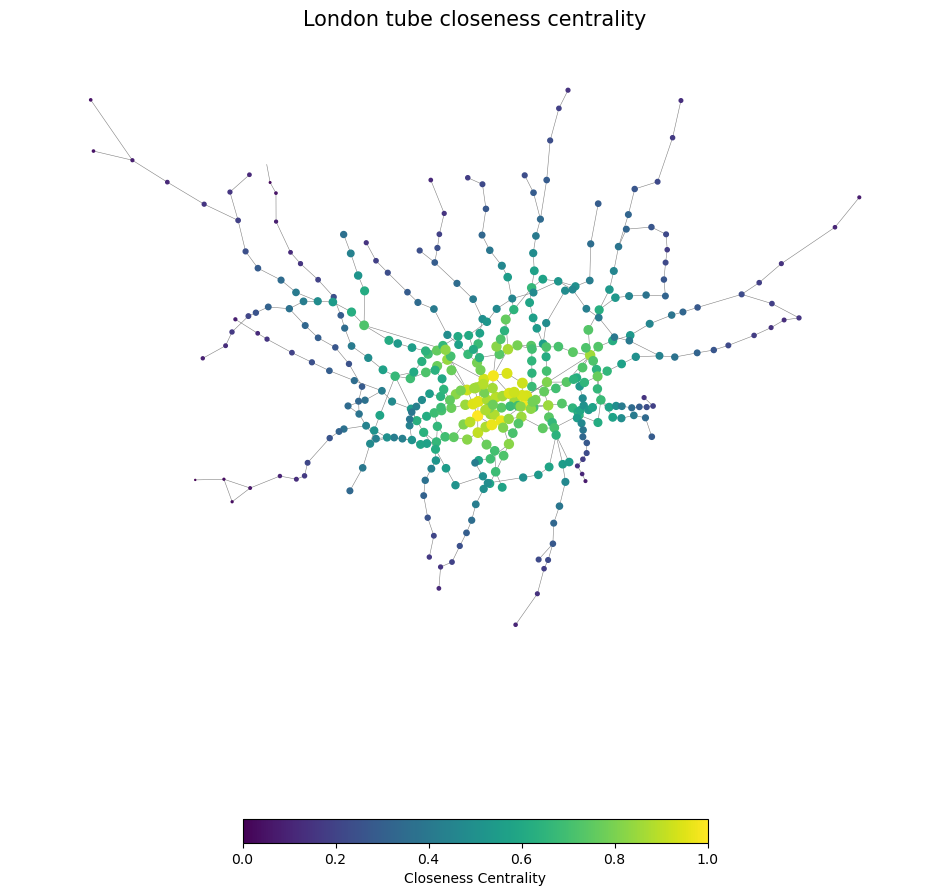

In [14]:
# Set colour and size of nodes according to closeness values.
closeness_values = [(i[1]['closeness']) for i in G.nodes(data=True)]
clo_color = [(i[1]['closeness']-min(closeness_values))/(max(closeness_values)-min(closeness_values)) for i in G.nodes(data=True)]
clo_size = [((i[1]['closeness']-min(closeness_values))/(max(closeness_values)-min(closeness_values))*50) for i in G.nodes(data=True)]

# Plot graph.
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, 
                       pos, 
                       edge_color='gray', 
                       width=0.4)

nod = nx.draw_networkx_nodes(G, 
                             pos=pos, 
                             node_color=clo_color, 
                             cmap=plt.cm.viridis, 
                             node_size=clo_size)

plt.colorbar(nod, label="Closeness Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube closeness centrality", fontsize=15)
plt.show()

#### Eigenvector Centrality

In [15]:
# Calculate the eigenvector centrality.
try:
    # Try using a higher max_iter value.
    egi_london = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
    nx.set_node_attributes(G, egi_london, 'eigenvector')
except nx.PowerIterationFailedConvergence as e:
    print(f"The algorithm failed to converge within the increasing number of iterations: {e}")

In [16]:
# Add eigenvector centrality to dataframe.
df['eigenvector'] = pd.Series(nx.get_node_attributes(G, 'eigenvector'))

df_sorted = df.sort_values(["eigenvector"], ascending=False)
df_sorted[0:10]

betweenness  closeness  eigenvector
Bank and Monument     0.290489   0.113572     0.383427
Liverpool Street      0.270807   0.110254     0.328824
Stratford             0.297846   0.104384     0.269179
Waterloo              0.243921   0.112265     0.249731
Moorgate              0.130169   0.110314     0.215137
Green Park            0.215835   0.114778     0.197630
Oxford Circus         0.053844   0.111204     0.184094
Tower Hill            0.002399   0.102276     0.171676
Westminster           0.203335   0.112549     0.168610
Shadwell              0.045432   0.103842     0.159090

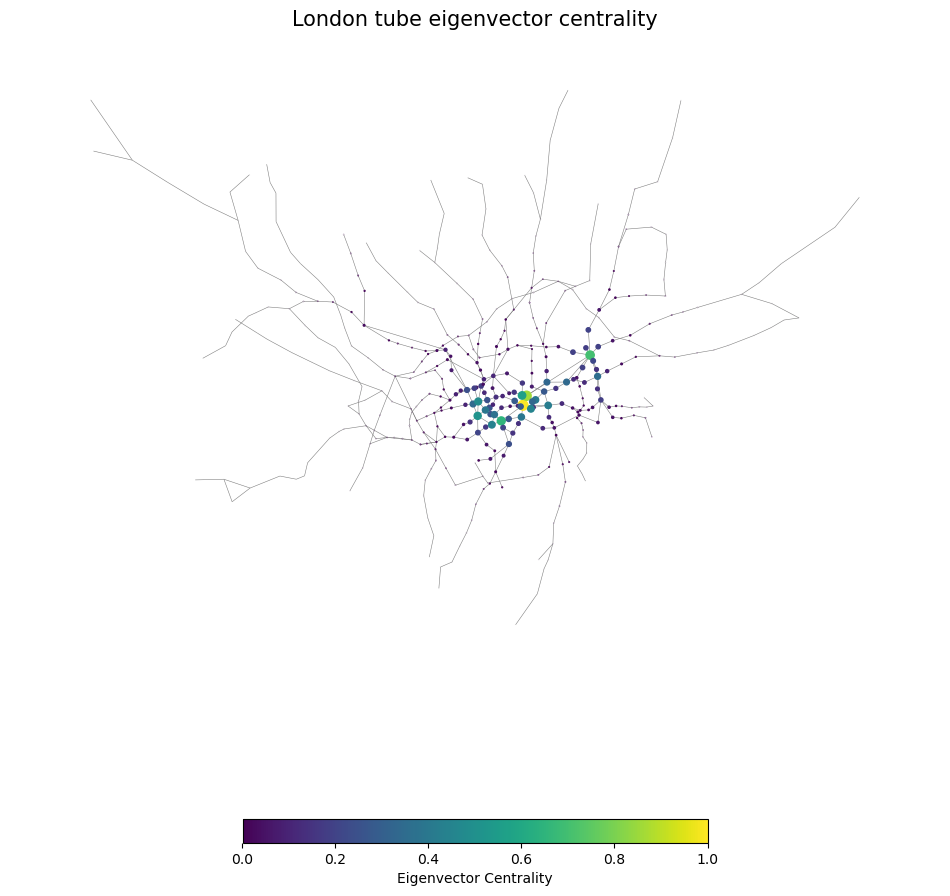

In [17]:
# Set colour and size of nodes according to eigenvector values.
eigenvector_values = [(i[1]['eigenvector']) for i in G.nodes(data=True)]
egi_color = [(i[1]['eigenvector'])/(max(eigenvector_values)) for i in G.nodes(data=True)]
egi_size = [(i[1]['eigenvector'])/(max(eigenvector_values))*50 for i in G.nodes(data=True)]

# Plot graph.
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, 
                       pos, 
                       edge_color='gray', 
                       width=0.4)

nod = nx.draw_networkx_nodes(G, 
                             pos=pos, 
                             node_color=egi_color, 
                             cmap=plt.cm.viridis, 
                             node_size=egi_size)

plt.colorbar(nod, label="Eigenvector Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube eigenvector centrality", fontsize=15)
plt.show()

#### Summary

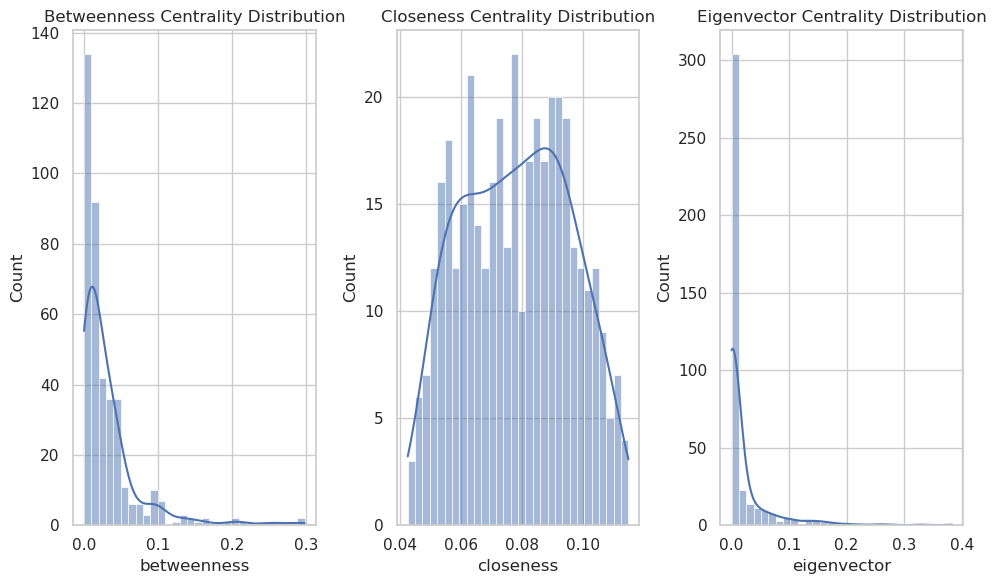

In [18]:
# Plot the distribution of centralities.
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

# betweenness centrality distribution
sns.histplot(data=df, x="betweenness", bins=30, kde=True, ax=axes[0])
axes[0].set_title("Betweenness Centrality Distribution")

# close centrality distribution
sns.histplot(data=df, x="closeness", bins=30, kde=True, ax=axes[1])
axes[1].set_title("Closeness Centrality Distribution")

# eigenvector centrality distribution
sns.histplot(data=df, x="eigenvector", bins=30, kde=True, ax=axes[2])
axes[2].set_title("Eigenvector Centrality Distribution")

plt.tight_layout()
plt.show()

In [19]:
# Rank each type of centrality and extract the top ten.
top_betweenness = df.nlargest(10, 'betweenness')[['betweenness']]
top_closeness = df.nlargest(10, 'closeness')[['closeness']]
top_eigenvector = df.nlargest(10, 'eigenvector')[['eigenvector']]

top_betweenness.reset_index(inplace=True)
top_closeness.reset_index(inplace=True)
top_eigenvector.reset_index(inplace=True)

top_centralities = pd.concat([top_betweenness, top_closeness, top_eigenvector], axis=1)

top_centralities

index  betweenness                     index  closeness  \
0                 Stratford     0.297846                Green Park   0.114778   
1         Bank and Monument     0.290489         Bank and Monument   0.113572   
2          Liverpool Street     0.270807  King's Cross St. Pancras   0.113443   
3  King's Cross St. Pancras     0.255307               Westminster   0.112549   
4                  Waterloo     0.243921                  Waterloo   0.112265   
5                Green Park     0.215835             Oxford Circus   0.111204   
6                    Euston     0.208324               Bond Street   0.110988   
7               Westminster     0.203335                     Angel   0.110742   
8              Baker Street     0.191568                Farringdon   0.110742   
9             Finchley Road     0.165085                  Moorgate   0.110314   

               index  eigenvector  
0  Bank and Monument     0.383427  
1   Liverpool Street     0.328824  
2          Stratford     0.269179  
3           Waterloo     0.249731  
4           Moorgate     0.215137  
5         Green Park     0.197630  
6      Oxford Circus     0.184094  
7         Tower Hill     0.171676  
8        Westminster     0.168610  
9           Shadwell     0.159090

In [71]:
top_centralities.to_csv("top_centralities.csv", index=False)

### I.2. Impact measures

#### Global Efficiency

In [20]:
# Taking G as an example to calculate the global efficiency.
global_eff = nx.global_efficiency(G)
print("Global Efficiency of the network G is:", global_eff)

Global Efficiency of the network G is: 0.10125619359720932


#### Normalized Largest Connected Component

In [21]:
# # Taking G as an example to calculate the NLCC.

# # Compute all connected components.
# connected_components = list(nx.connected_components(G))

# # Find the largest connected component.
# largest_cc = max(connected_components, key=len)

# # Compute the size of the normalized largest connected component.
# NLCC = len(largest_cc) / G.number_of_nodes()

# print("Normalized Largest Connected Component size of the network G is:", NLCC)

In [22]:
def calculate_nlcc(G):
    """
    Calculate the Normalized Largest Connected Component (NLCC) size of a graph.

    Parameters:
    - G: A NetworkX graph object (undirected).

    Returns:
    - The size of the largest connected component, normalized by the total number of nodes in the graph.
    """
    # Make sure G is an undirected graph.
    if G.is_directed():
        raise ValueError("G must be an undirected graph.")

    # Compute all connected components.
    connected_components = list(nx.connected_components(G))
    
    # Find the largest connected component.
    largest_cc = max(connected_components, key=len)
    
    # Compute the size of the normalized largest connected component.
    normalized_largest_cc_size = len(largest_cc) / G.number_of_nodes()
    
    return normalized_largest_cc_size

In [23]:
# Taking G as an example to calculate the NLCC.
NLCC = calculate_nlcc(G)
print("Normalized Largest Connected Component size of the network G is:", NLCC)

Normalized Largest Connected Component size of the network G is: 1.0


### I.3. Node removal

#### A) Non-sequential removal

In [24]:
# To check node attributes.
list(G.nodes(data = True))[0]

('Stratford',
 {'coords': (538524.7855297636, 184373.34100822973),
  'betweenness': 0.2978457823852564,
  'closeness': 0.10438413361169102,
  'eigenvector': 0.26917936110280577})

In [25]:
# Plotting functions for visualizing centrality.
def plot_result_network(G, measure):

    values = [data[measure] for _, data in G.nodes(data=True)]
    min_value, max_value = min(values), max(values)
    
    color = [(value - min_value) / (max_value - min_value) for value in values]
    size = [((value - min_value) / (max_value - min_value) * 50) + 10 for value in values]  # 添加基础大小以避免太小的节点
    
    fig, ax = plt.subplots(figsize=(12, 12))
    pos = nx.get_node_attributes(G, 'coords')

    nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4)

    nodes = nx.draw_networkx_nodes(G, pos, node_color=color, cmap=plt.cm.viridis, node_size=size)

    plt.colorbar(nodes, label=f"{measure.capitalize()} Centrality", orientation="horizontal", shrink=0.5)

    plt.axis("off")
    plt.title(f"Network {measure.capitalize()} Centrality", fontsize=15)
    plt.show()

In [67]:
# Plotting function for visualizing connected components.
def plot_result_network_cc(G, measure):
    # Get all connected components of G.
    connected_components = list(nx.connected_components(G))
    
    plt.figure(figsize=(12, 8))
    
    for i, nodes in enumerate(connected_components):
        # Extract the subgraph of the current connected components.
        subgraph = G.subgraph(nodes)
        
        # Generate layout for subgraphs.
        pos = nx.get_node_attributes(G, 'coords')

        node_labels = {node: node for node in G.nodes()}

        nx.draw_networkx_edges(subgraph, pos, edge_color='gray', width=0.4)
        nx.draw_networkx_nodes(subgraph, pos, node_color=f'C{i}', node_size=30)
        # nx.draw_networkx_labels(subgraph, pos, node_labels, font_size=7, font_color='black')
    
    plt.axis('off')
    plt.title(f'Connected Components of {measure.capitalize()} Centrality', fontsize=15)
    plt.show()

In [68]:
# List of centrality measures.
measure_names = ['betweenness', 'closeness', 'eigenvector']

# Data structure to store results.
results_a = []

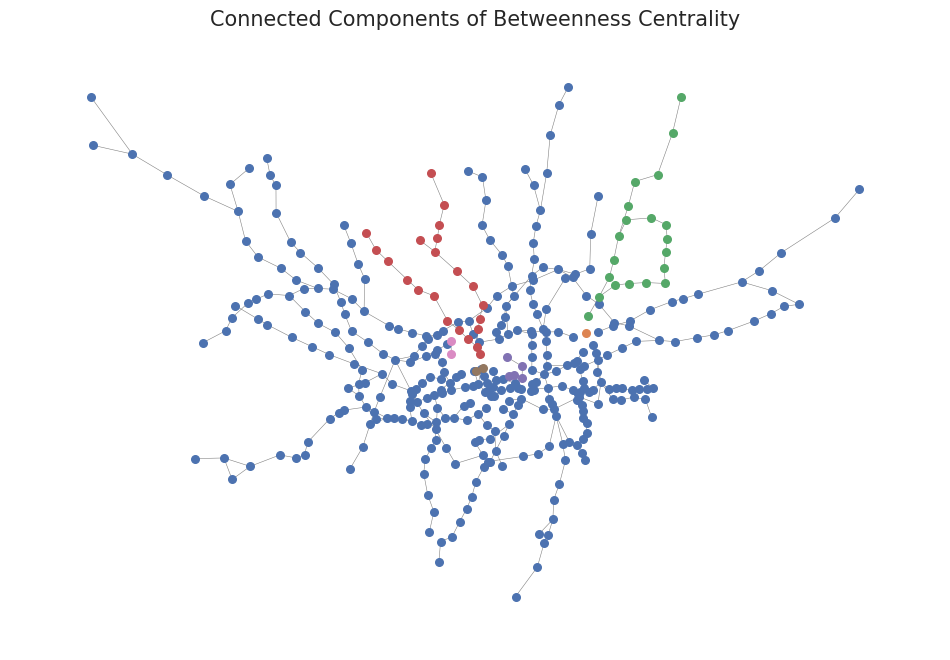

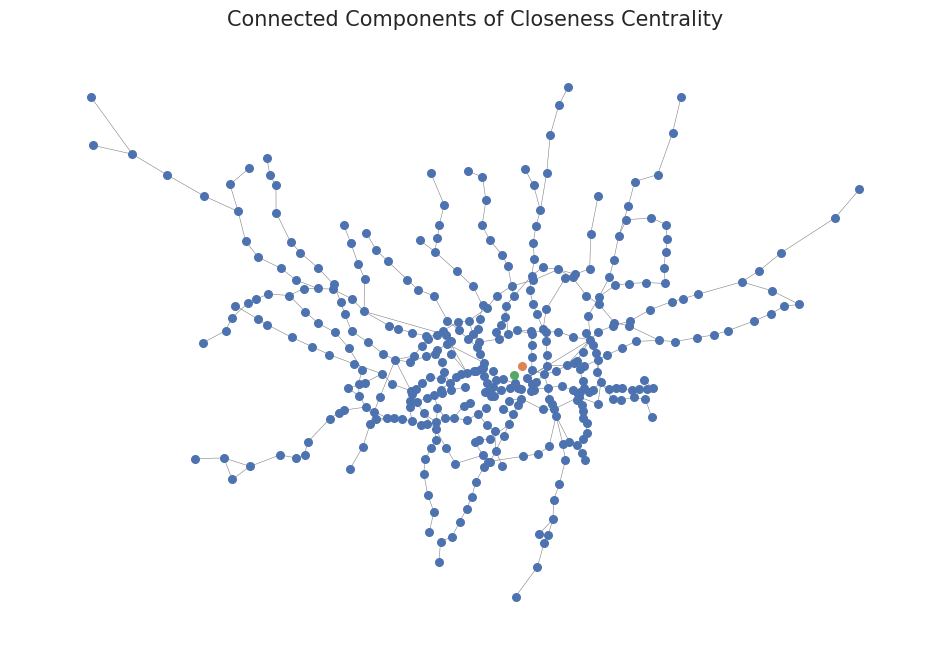

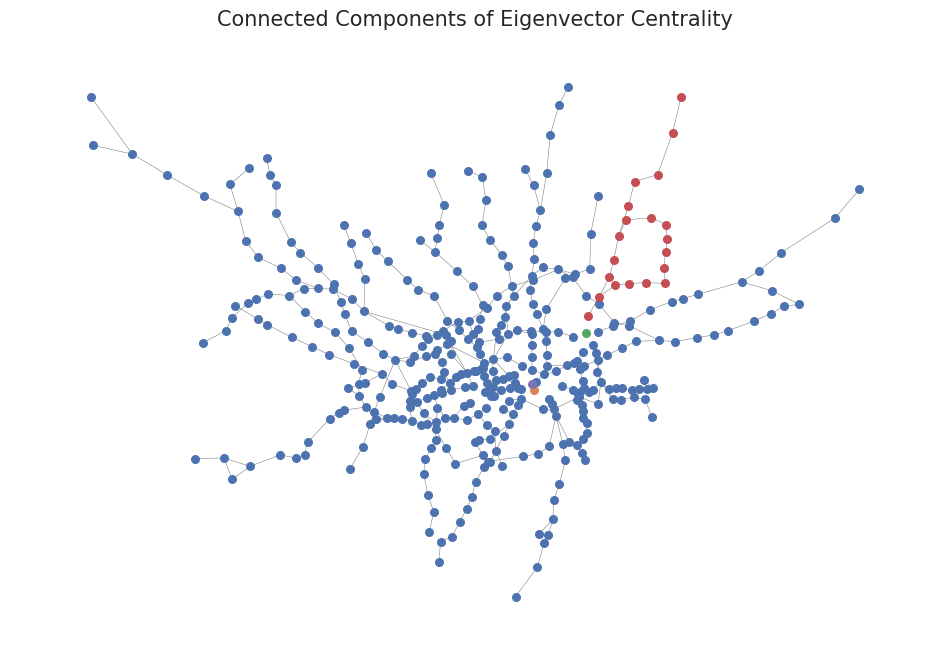

In [69]:
# For each centrality measure.
for measure in measure_names:
    G_temp = G.copy()
    efficiency = []
    nlcc = []
    
    # Get all nodes and their centrality measures.
    centrality_values = {node: data[measure] for node, data in G_temp.nodes(data=True)}
    
    # Sort nodes by centrality measure from largest to smallest.
    sorted_nodes = sorted(centrality_values, key=centrality_values.get, reverse=True)
    
    # Delete the first 10 nodes after sorting and calculate the global efficiency and NLCC.
    for i in range(min(10, len(sorted_nodes))):
        node_to_remove = sorted_nodes[i]
        G_temp.remove_node(node_to_remove)
        
        # Calculate global efficiency and NLCC after each node is deleted.
        efficiency.append(nx.global_efficiency(G_temp))
        nlcc.append(calculate_nlcc(G_temp))
        
    # Add results to results_a.
    results_a.append({
        'measure': measure,
        'efficiency': efficiency,
        'nlcc': nlcc   
    })

    # plot_result_network(G_temp, measure)
    plot_result_network_cc(G_temp, measure)

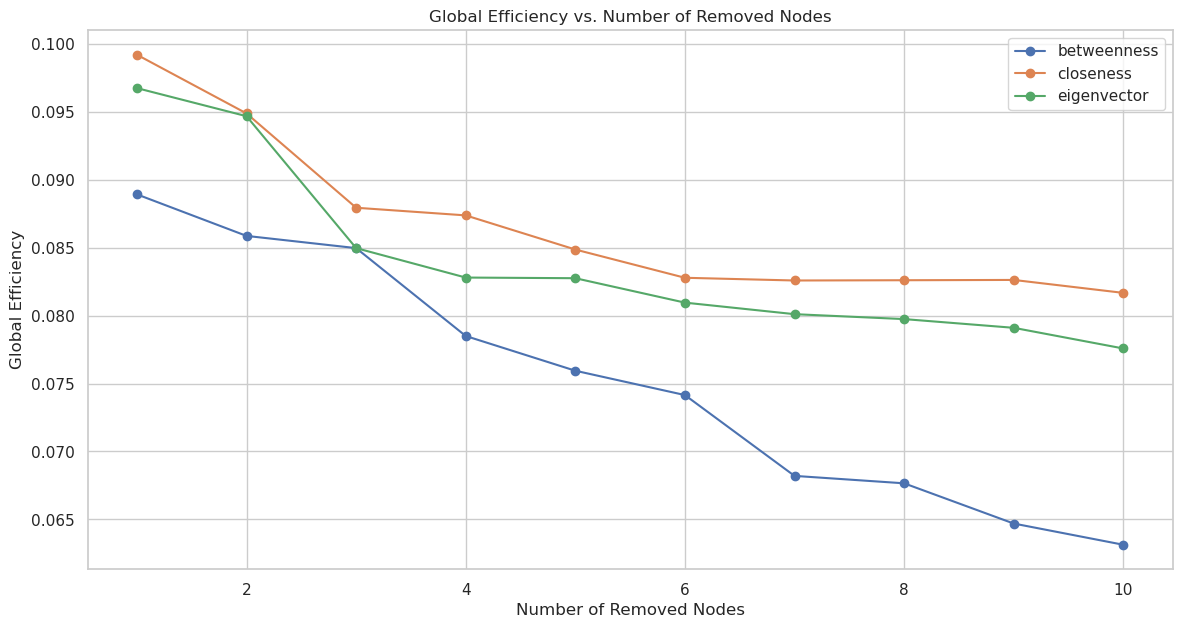

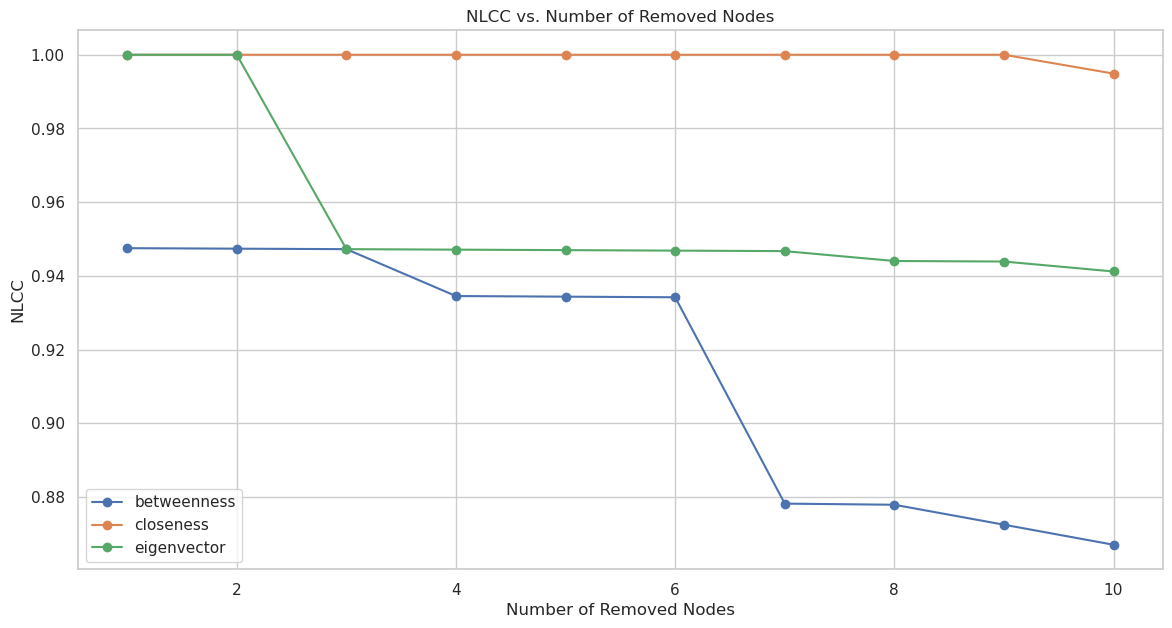

In [29]:
# Global efficiency.
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the global efficiency curve.
for entry in results_a:
    plt.plot(range(1, 11), entry['efficiency'], '-o', label=entry['measure'])

plt.title('Global Efficiency vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('Global Efficiency')
plt.legend()
plt.show()

# NLCC
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the NLCC curve.
for entry in results_a:
    plt.plot(range(1, 11), entry['nlcc'], '-o', label=entry['measure'])

plt.title('NLCC vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('NLCC')
plt.legend()
plt.show()

#### B) Sequential removal

In [30]:
# Add NetworkX's centrality calculation function to the dictionary.
centrality_functions = {
    'betweenness': nx.betweenness_centrality,
    'closeness': nx.closeness_centrality,
    'eigenvector': lambda G: nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
}

# Data structure to store results.
results_b = []

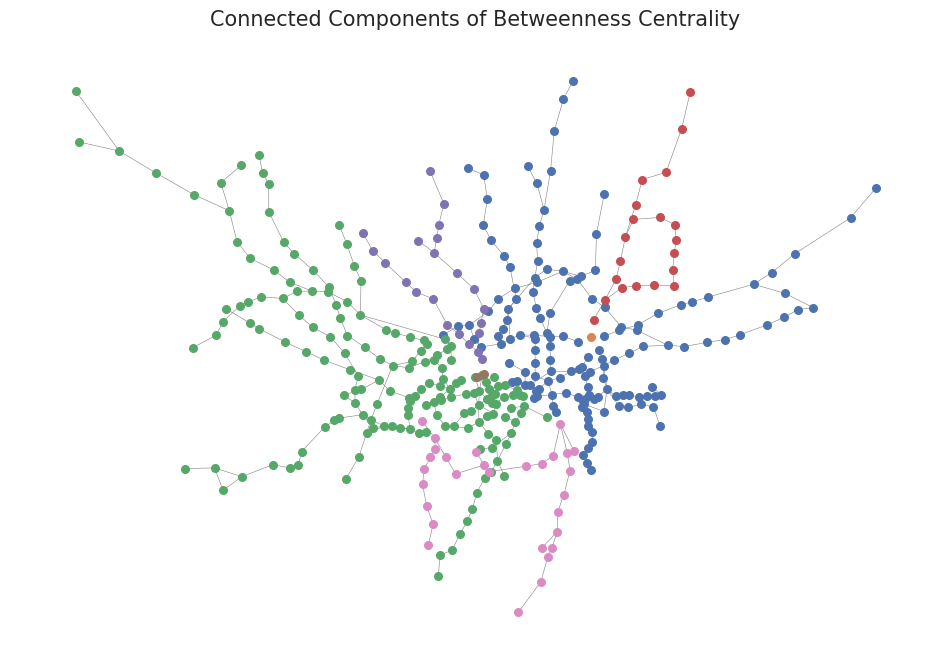

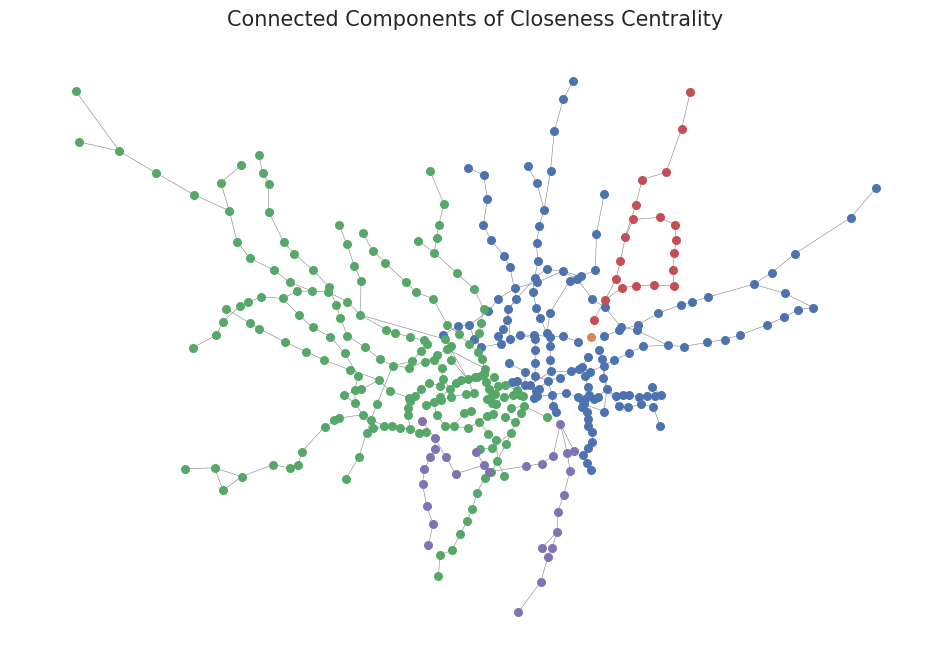

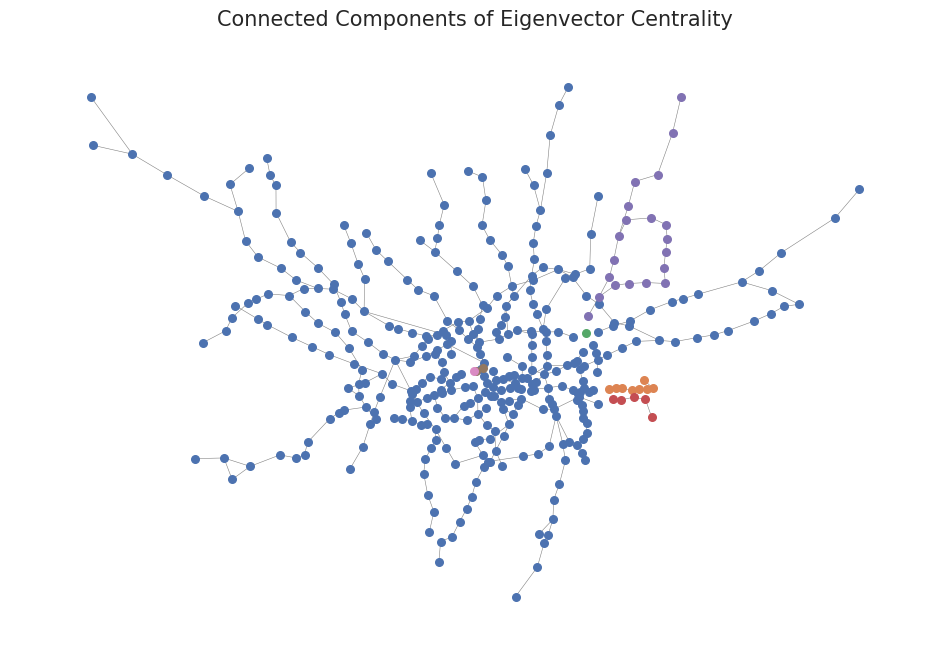

In [70]:
for measure in centrality_functions.keys():
    G_temp = G.copy()
    efficiency = []
    nlcc = []
    
    # Perform node deletion 10 times.
    for i in range(10):
        # Recalculate the centrality of the current graph.
        current_centrality = centrality_functions[measure](G_temp)
        
        # Find the node with the highest centrality.
        max_node = max(current_centrality, key=current_centrality.get)
        
        # Delete the node.
        G_temp.remove_node(max_node)
        
        # Calculate global efficiency and NLCC and add to list.
        efficiency.append(nx.global_efficiency(G_temp))
        nlcc.append(calculate_nlcc(G_temp))
        
    # Add results to results list.
    results_b.append({
        'measure': measure,
        'efficiency': efficiency,
        'nlcc': nlcc
    })

    # plot_result_network(G_temp, measure)
    plot_result_network_cc(G_temp, measure)

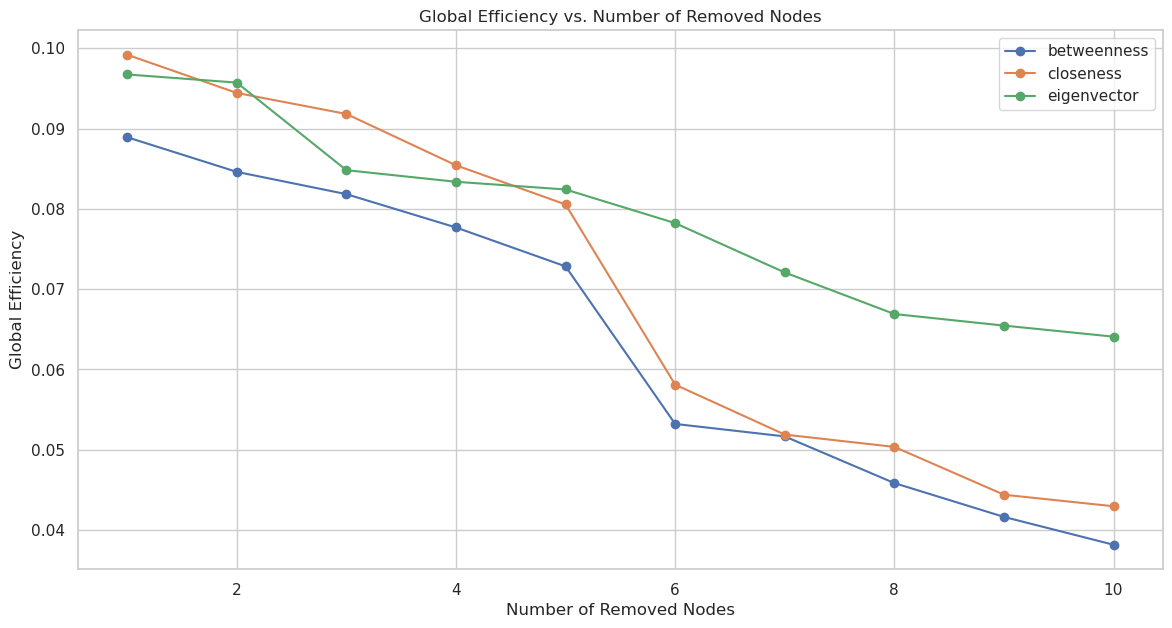

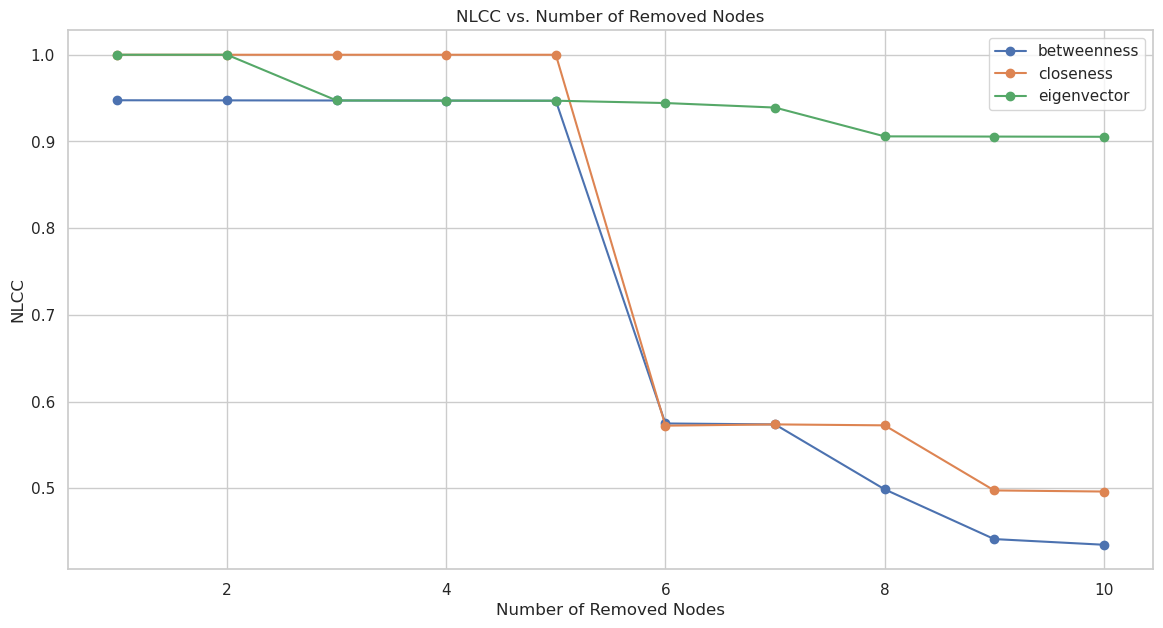

In [32]:
# Global efficiency.
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the global efficiency curve.
for entry in results_b:
    plt.plot(range(1, 11), entry['efficiency'], '-o', label=entry['measure'])

plt.title('Global Efficiency vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('Global Efficiency')
plt.legend()
plt.show()

# NLCC
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the NLCC curve.
for entry in results_b:
    plt.plot(range(1, 11), entry['nlcc'], '-o', label=entry['measure'])

plt.title('NLCC vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('NLCC')
plt.legend()
plt.show()

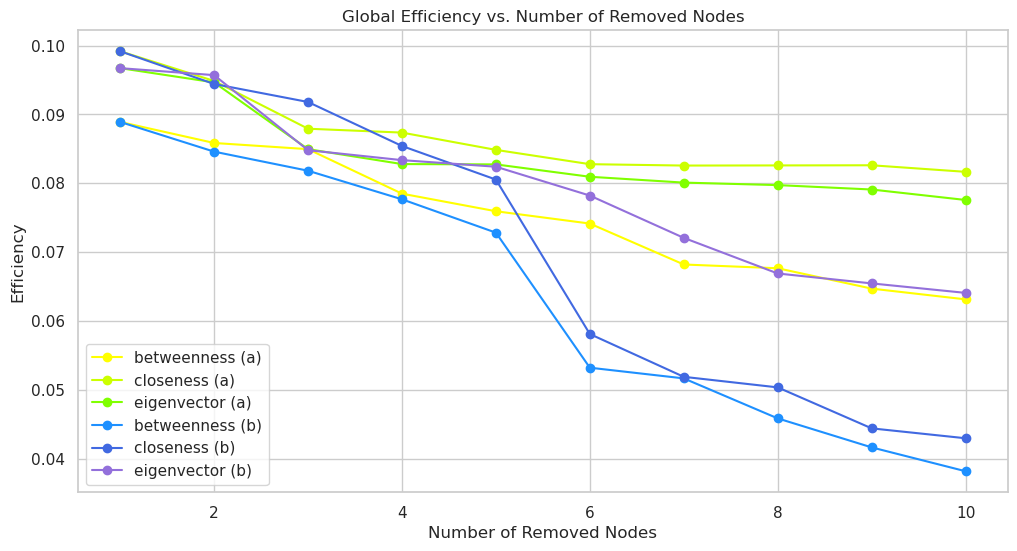

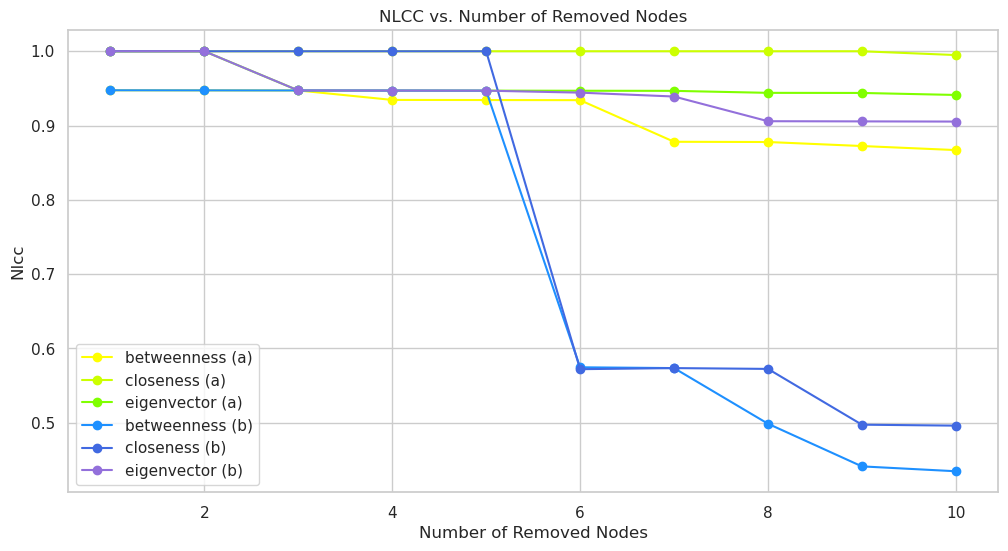

In [33]:
# Define color gradient.
gradients_a = ['#FFFF00', '#CCFF00', '#80FF00', '#33CC33']
gradients_b = ['#1E90FF', '#4169E1', '#9370DB', '#8A2BE2']

# Function used to graph a measure.
def plot_measure(results_a, results_b, measure, title):
    plt.figure(figsize=(12, 6))

    # Plot the results of results_a.
    for idx, entry in enumerate(results_a):
        plt.plot(range(1, 11), entry[measure], '-o', label=f'{entry["measure"]} (a)', color=gradients_a[idx])

    # Plot the results of results_b.
    for idx, entry in enumerate(results_b):
        plt.plot(range(1, 11), entry[measure], '-o', label=f'{entry["measure"]} (b)', color=gradients_b[idx])

    plt.title(title)
    plt.xlabel('Number of Removed Nodes')
    plt.ylabel(measure.capitalize().replace('_', ' '))
    plt.legend()
    plt.grid(True)
    plt.show()

# Global efficiency.
plot_measure(results_a, results_b, 'efficiency', 'Global Efficiency vs. Number of Removed Nodes')

# NLCC.
plot_measure(results_a, results_b, 'nlcc', 'NLCC vs. Number of Removed Nodes')

## II. Flows: weighted network

#### Preprocessing

In [34]:
# Filter edges with flow 0.
zero_flow_edges = [(u, v, attr) for u, v, attr in G.edges(data=True) if 'flows' in attr and attr['flows'] == 0]

for edge in zero_flow_edges:
    u, v, attr = edge
    print(f"Edge from {u} to {v} with attributes {attr}")

Edge from Kennington to Nine Elms with attributes {'length': 2030.621842856102, 'line_name': 'Northern', 'flows': 0}
Edge from Battersea Power Station to Nine Elms with attributes {'length': 1073.4653619689052, 'line_name': 'Northern', 'flows': 0}
Edge from Wandsworth Road to Battersea Park with attributes {'length': 1168.4892614627925, 'line_name': 'London Overground', 'flows': 0}


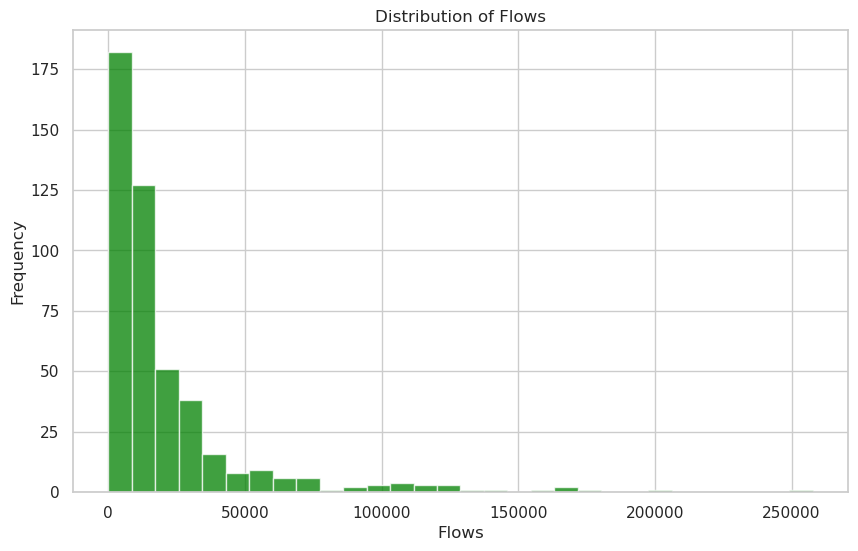

In [74]:
# Extract flows attribute of all edges.
flows = [data['flows'] for _, _, data in G.edges(data=True)]

# Plot the distribution of flows.
plt.figure(figsize=(10, 6))
plt.hist(flows, bins=30, alpha=0.75, color='green')
plt.title('Distribution of Flows')
plt.xlabel('Flows')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [36]:
# Preprocessing weights.
for u, v, d in G.edges(data=True):
    flow_value = d.get('flows', 0)
    d['reciprocal_flow'] = 1.0 / flow_value if flow_value > 0 else 1e-5

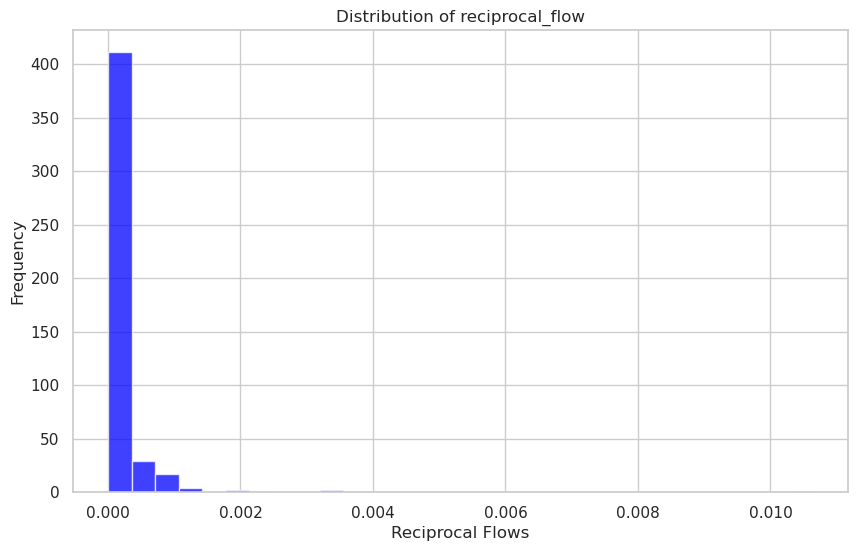

In [37]:
# Extract reciprocal_flow attribute of all edges.
flows = [data['reciprocal_flow'] for _, _, data in G.edges(data=True)]

# Plot the distribution of flows.
plt.figure(figsize=(10, 6))
plt.hist(flows, bins=30, alpha=0.75, color='blue')
plt.title('Distribution of reciprocal_flow')
plt.xlabel('Reciprocal Flows')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [38]:
# To check edges attributes.
list(G.edges(data = True))[0]

('Stratford',
 'Stratford High Street',
 {'length': 519.300073543952,
  'line_name': 'DLR',
  'flows': 1089,
  'reciprocal_flow': 0.0009182736455463728})

### II.1.

#### Weighted Betweenness Centrality

In [39]:
# Calculate the weighted betweenness centrality.
w_bet_london = nx.betweenness_centrality(G, weight='reciprocal_flow')
nx.set_node_attributes(G,w_bet_london,'w_betweenness')

In [40]:
# Add weighted betweenness centrality to dataframe.
df['w_betweenness'] = pd.Series(nx.get_node_attributes(G, 'w_betweenness'))

df_sorted = df.sort_values(["w_betweenness"], ascending=False)
df_sorted[0:10]

betweenness  closeness  eigenvector  w_betweenness
Green Park            0.215835   0.114778     0.197630       0.577657
Bank and Monument     0.290489   0.113572     0.383427       0.516579
Waterloo              0.243921   0.112265     0.249731       0.392180
Westminster           0.203335   0.112549     0.168610       0.356291
Liverpool Street      0.270807   0.110254     0.328824       0.341003
Stratford             0.297846   0.104384     0.269179       0.333910
Euston                0.208324   0.109830     0.038323       0.285238
Oxford Circus         0.053844   0.111204     0.184094       0.274799
Victoria              0.094262   0.108137     0.078994       0.271479
Bond Street           0.141591   0.110988     0.131473       0.256353

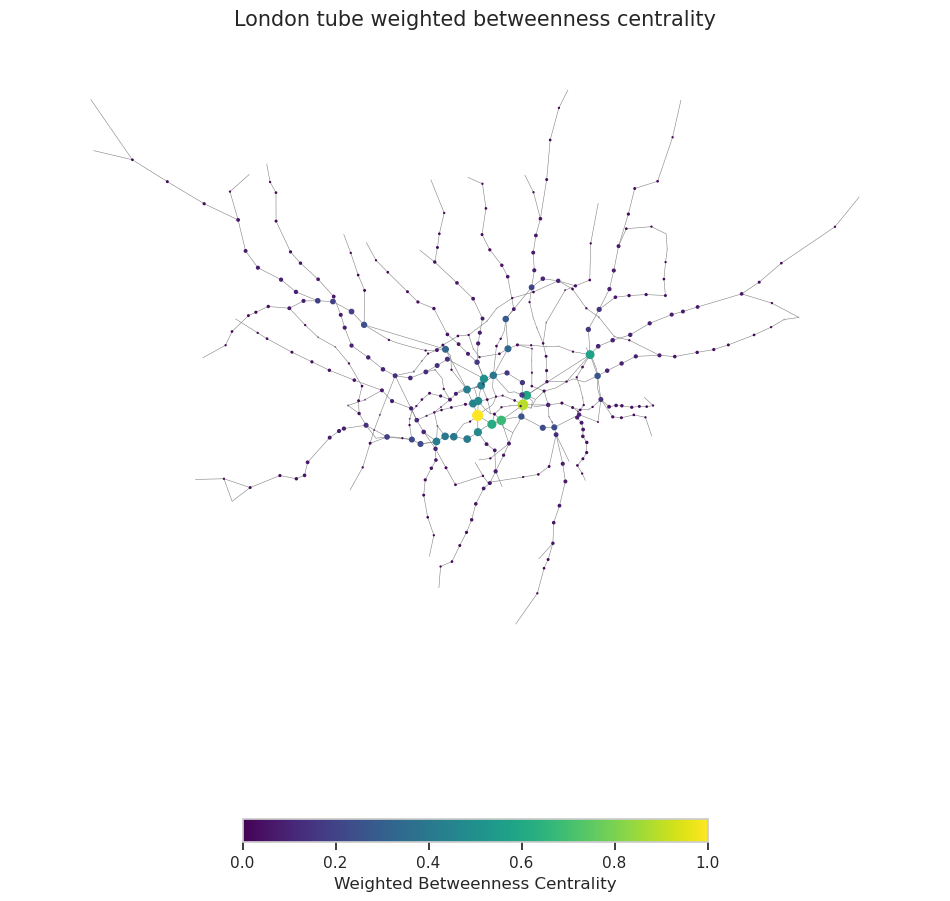

In [41]:
# Set colour and size of nodes according to weighted betweenness values.
w_betweenness_values = [(i[1]['w_betweenness']) for i in G.nodes(data=True)]
w_bet_color = [(i[1]['w_betweenness']/max(w_betweenness_values)) for i in G.nodes(data=True)]
w_bet_size = [(i[1]['w_betweenness']/max(w_betweenness_values))*50 for i in G.nodes(data=True)]

# Plot graph.
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, 
                       pos=pos, 
                       edge_color='gray', 
                       width=0.4)

nod=nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_color=w_bet_color, 
                           cmap=plt.cm.viridis, 
                           node_size=w_bet_size)

plt.colorbar(nod, label="Weighted Betweenness Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube weighted betweenness centrality", fontsize=15)
plt.show()

#### Weighted Closeness Centrality

In [42]:
# Calculate the weighted closeness centrality.
w_clo_london = nx.closeness_centrality(G, distance='reciprocal_flow')
nx.set_node_attributes(G, w_clo_london, 'w_closeness')

In [43]:
# Add weighted closeness centrality to dataframe.
df['w_closeness'] = pd.Series(nx.get_node_attributes(G, 'w_closeness'))

df_sorted = df.sort_values(["w_closeness"], ascending=False)
df_sorted[0:10]

betweenness  closeness  eigenvector  w_betweenness  \
Green Park            0.215835   0.114778     0.197630       0.577657   
Westminster           0.203335   0.112549     0.168610       0.356291   
Waterloo              0.243921   0.112265     0.249731       0.392180   
Bank and Monument     0.290489   0.113572     0.383427       0.516579   
Victoria              0.094262   0.108137     0.078994       0.271479   
Oxford Circus         0.053844   0.111204     0.184094       0.274799   
Bond Street           0.141591   0.110988     0.131473       0.256353   
Liverpool Street      0.270807   0.110254     0.328824       0.341003   
Warren Street         0.042792   0.106242     0.068157       0.254737   
Sloane Square         0.069249   0.101859     0.023291       0.236516   

                   w_closeness  
Green Park         2389.509504  
Westminster        2383.512593  
Waterloo           2378.572905  
Bank and Monument  2374.731648  
Victoria           2368.997026  
Oxford Circus      2368.762530  
Bond Street        2357.709176  
Liverpool Street   2355.590642  
Warren Street      2344.825372  
Sloane Square      2335.680183

In [44]:
# # Find the maximum closeness centrality value.
# max_closeness = max(w_clo_london.values())

# # Normalization.
# normalized_closeness = {node: closeness / max_closeness for node, closeness in w_clo_london.items()}

# # Set normalized closeness centrality value to node attribute.
# nx.set_node_attributes(G, normalized_closeness, 'normalized_w_closeness')

In [45]:
# # Add weighted closeness centrality to dataframe.
# df['normalized_w_closeness'] = pd.Series(nx.get_node_attributes(G, 'normalized_w_closeness'))

# df_sorted = df.sort_values(["normalized_w_closeness"], ascending=False)
# df_sorted[0:10]

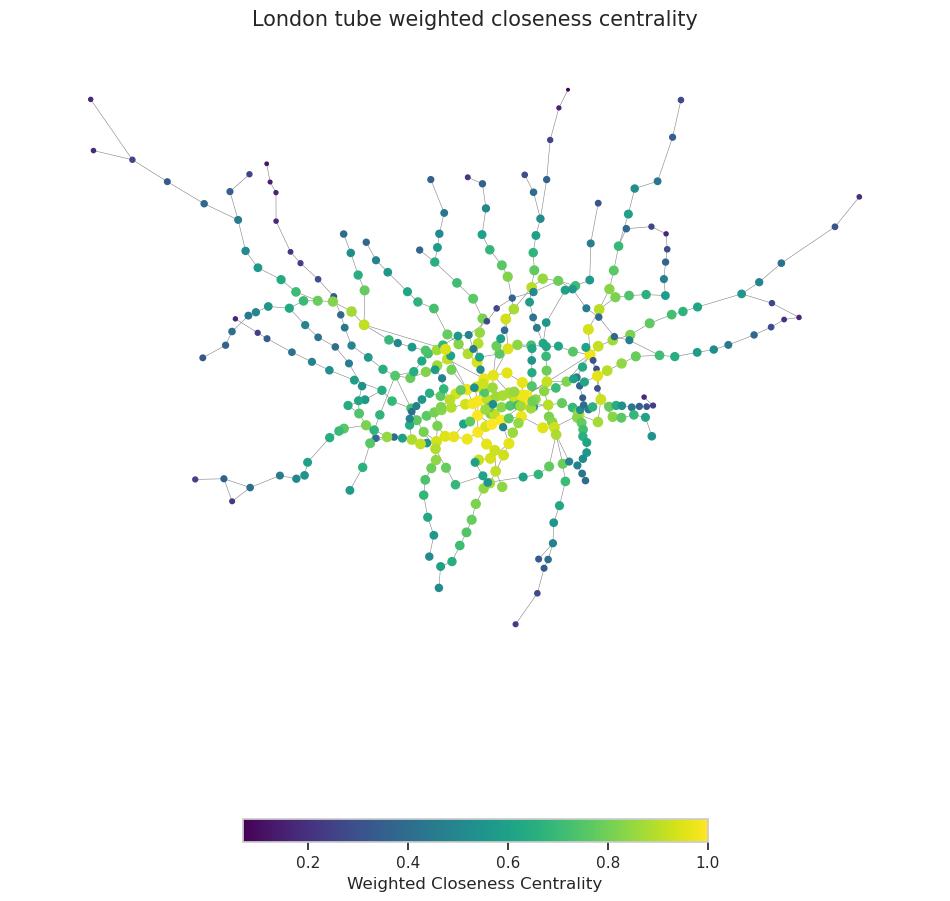

In [46]:
# Set colour and size of nodes according to weighted closeness values.
w_closeness_values = [(i[1]['w_closeness']) for i in G.nodes(data=True)]
w_clo_color = [(i[1]['w_closeness']/max(w_closeness_values)) for i in G.nodes(data=True)]
w_clo_size = [(i[1]['w_closeness']/max(w_closeness_values))*50 for i in G.nodes(data=True)]

# Plot graph.
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, 
                       pos=pos, 
                       edge_color='gray', 
                       width=0.4)

nod=nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_color=w_clo_color, 
                           cmap=plt.cm.viridis, 
                           node_size=w_clo_size)

plt.colorbar(nod, label="Weighted Closeness Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube weighted closeness centrality", fontsize=15)
plt.show()

#### Weighted Eigenvector Centrality

In [47]:
# Calculate the weighted eigenvector centrality.
try:
    # Try using a higher max_iter value.
    w_egi_london = nx.eigenvector_centrality(G, weight='flows', max_iter=1000, tol=1e-06)
    nx.set_node_attributes(G, w_egi_london, 'w_eigenvector')
except nx.PowerIterationFailedConvergence as e:
    print(f"The algorithm failed to converge within the increasing number of iterations: {e}")

In [48]:
# Add weighted eigenvector centrality to dataframe.
df['w_eigenvector'] = pd.Series(nx.get_node_attributes(G, 'w_eigenvector'))

df_sorted = df.sort_values(["w_eigenvector"], ascending=False)
df_sorted[0:10]

betweenness  closeness  eigenvector  w_betweenness  \
Waterloo              0.243921   0.112265     0.249731       0.392180   
Bank and Monument     0.290489   0.113572     0.383427       0.516579   
Westminster           0.203335   0.112549     0.168610       0.356291   
Green Park            0.215835   0.114778     0.197630       0.577657   
Liverpool Street      0.270807   0.110254     0.328824       0.341003   
London Bridge         0.081346   0.104004     0.150175       0.146742   
Victoria              0.094262   0.108137     0.078994       0.271479   
Moorgate              0.130169   0.110314     0.215137       0.096316   
Oxford Circus         0.053844   0.111204     0.184094       0.274799   
Stratford             0.297846   0.104384     0.269179       0.333910   

                   w_closeness  w_eigenvector  
Waterloo           2378.572905       0.532052  
Bank and Monument  2374.731648       0.516670  
Westminster        2383.512593       0.396107  
Green Park         2389.509504       0.302838  
Liverpool Street   2355.590642       0.268507  
London Bridge      2334.670259       0.151077  
Victoria           2368.997026       0.148907  
Moorgate           2330.720515       0.136849  
Oxford Circus      2368.762530       0.118060  
Stratford          2333.966199       0.110423

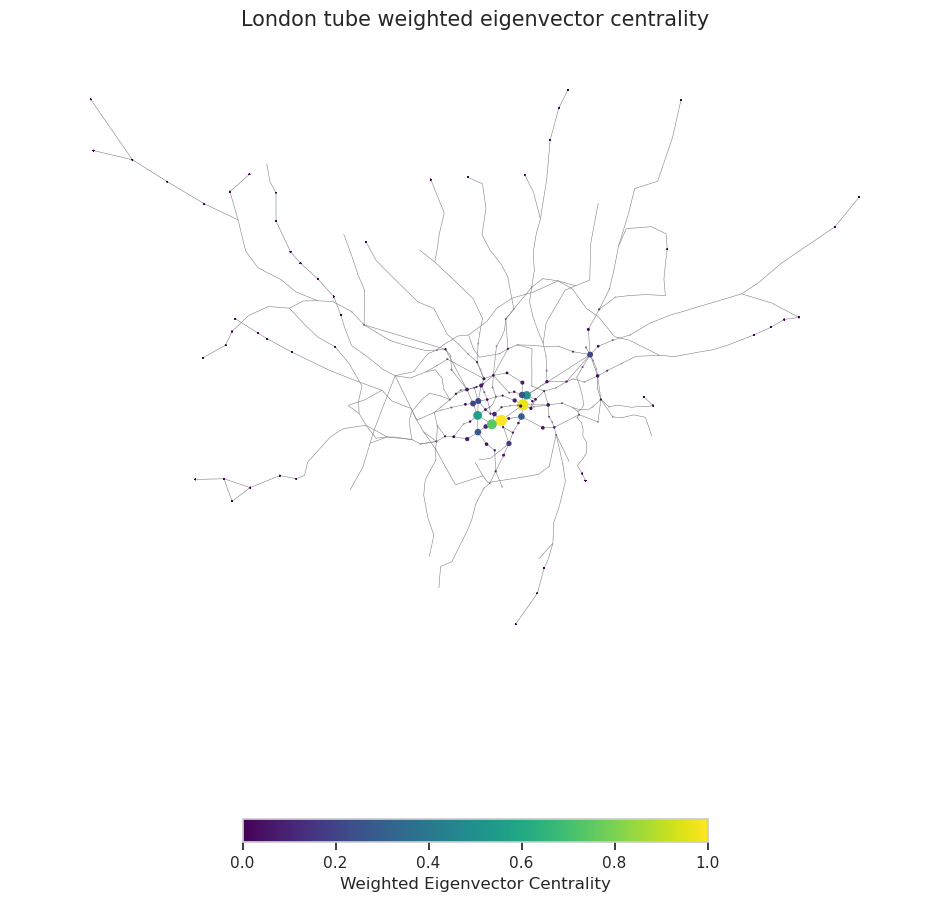

In [49]:
# Set colour and size of nodes according to weighted eigenvector values.
w_eigenvector_values = [(i[1]['w_eigenvector']) for i in G.nodes(data=True)]
w_egi_color = [(i[1]['w_eigenvector']/max(w_eigenvector_values)) for i in G.nodes(data=True)]
w_egi_size = [(i[1]['w_eigenvector']/max(w_eigenvector_values))*50 for i in G.nodes(data=True)]

# Plot graph.
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, 
                       pos=pos, 
                       edge_color='gray', 
                       width=0.4)

nod=nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_color=w_egi_color, 
                           cmap=plt.cm.viridis, 
                           node_size=w_egi_size)

plt.colorbar(nod, label="Weighted Eigenvector Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube weighted eigenvector centrality", fontsize=15)
plt.show()

#### Summary

In [50]:
# Rank each type of centrality and extract the top ten.
top_w_betweenness = df.nlargest(10, 'w_betweenness')[['w_betweenness']]
top_w_closeness = df.nlargest(10, 'w_closeness')[['w_closeness']]
top_w_eigenvector = df.nlargest(10, 'w_eigenvector')[['w_eigenvector']]

top_w_betweenness.reset_index(inplace=True)
top_w_closeness.reset_index(inplace=True)
top_w_eigenvector.reset_index(inplace=True)

top_w_centralities = pd.concat([top_w_betweenness, top_w_closeness, top_w_eigenvector], axis=1)

top_w_centralities

index  w_betweenness              index  w_closeness  \
0         Green Park       0.577657         Green Park  2389.509504   
1  Bank and Monument       0.516579        Westminster  2383.512593   
2           Waterloo       0.392180           Waterloo  2378.572905   
3        Westminster       0.356291  Bank and Monument  2374.731648   
4   Liverpool Street       0.341003           Victoria  2368.997026   
5          Stratford       0.333910      Oxford Circus  2368.762530   
6             Euston       0.285238        Bond Street  2357.709176   
7      Oxford Circus       0.274799   Liverpool Street  2355.590642   
8           Victoria       0.271479      Warren Street  2344.825372   
9        Bond Street       0.256353      Sloane Square  2335.680183   

               index  w_eigenvector  
0           Waterloo       0.532052  
1  Bank and Monument       0.516670  
2        Westminster       0.396107  
3         Green Park       0.302838  
4   Liverpool Street       0.268507  
5      London Bridge       0.151077  
6           Victoria       0.148907  
7           Moorgate       0.136849  
8      Oxford Circus       0.118060  
9          Stratford       0.110423

In [72]:
top_w_centralities.to_csv("top_w_centralities.csv", index=False)

### II.2.

#### Weighted Global Efficiency

In [51]:
def weighted_global_efficiency(G, weight='reciprocal_flow'):
    n = len(G)
    if n <= 1:
        return 0
    else:
        lengths = []
        # 对于图中的每对节点
        for node in G:
            path_length = nx.single_source_dijkstra_path_length(G, node, weight=weight)
            lengths.extend([1/length for target, length in path_length.items() if target != node])
        
        # 计算平均倒数路径长度
        ge = sum(lengths) / (n * (n - 1))
        return ge

In [52]:
# Taking G as an example to calculate the Weighted Global Efficiency.
w_global_eff = weighted_global_efficiency(G)
print("Weighted Global Efficiency of the network G is:", w_global_eff)

Weighted Global Efficiency of the network G is: 2711.8663061813845


### II.3.

In [108]:
# To check node attributes.
list(G.nodes(data = True))[0]

('Stratford',
 {'coords': (538524.7855297636, 184373.34100822973),
  'betweenness': 0.2978457823852564,
  'closeness': 0.10438413361169102,
  'eigenvector': 0.26917936110280577,
  'w_betweenness': 0.3339097744360902,
  'w_closeness': 2333.9661992488604,
  'w_eigenvector': 0.11042344179552588})

#### A) Non-sequential removal

In [109]:
# List of centrality measures.
w_measure_names = ['w_betweenness'] #, 'w_closeness', 'w_eigenvector'

# Data structure to store results.
results_a_w = []

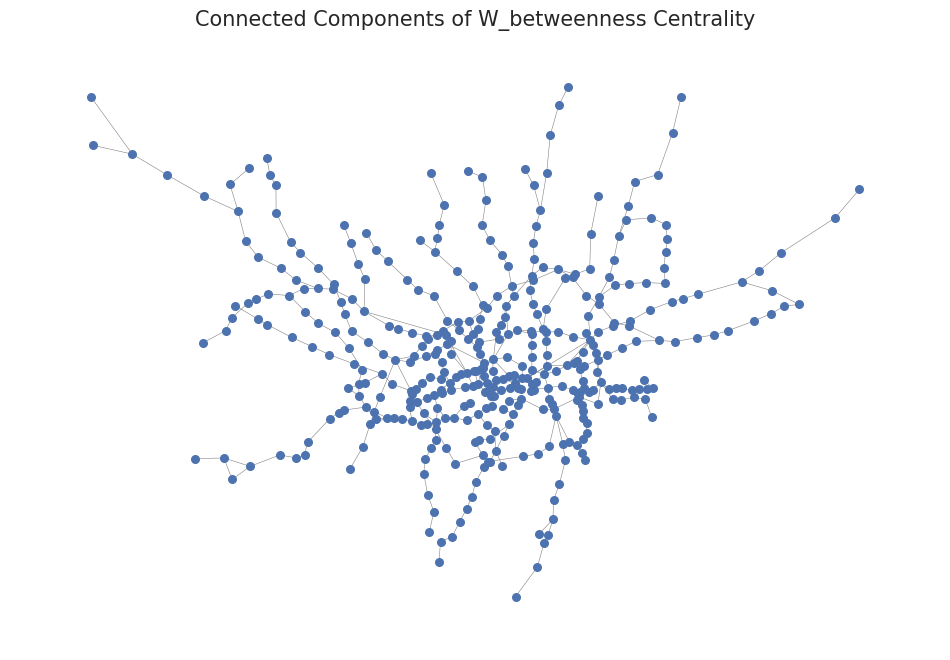

In [110]:
# For each centrality measure.
for measure in w_measure_names:
    G_temp = G.copy()
    efficiency = []
    nlcc = []
    w_efficiency = []
    
    # Get all nodes and their centrality measures.
    centrality_values = {node: data[measure] for node, data in G_temp.nodes(data=True)}
    
    # Sort nodes by centrality measure from largest to smallest.
    sorted_nodes = sorted(centrality_values, key=centrality_values.get, reverse=True)
    
    # Delete the first 10 nodes after sorting and calculate the global efficiency and NLCC.
    for i in range(min(3, len(sorted_nodes))):
        node_to_remove = sorted_nodes[i]
        G_temp.remove_node(node_to_remove)
        
        # Calculate global efficiency, weighted global efficiency and NLCC after each node is deleted.
        efficiency.append(nx.global_efficiency(G_temp))
        nlcc.append(calculate_nlcc(G_temp))
        w_efficiency.append(weighted_global_efficiency(G_temp))
        
    # Add results to results_a_w.
    results_a_w.append({
        'measure': measure,
        'efficiency': efficiency,
        'nlcc': nlcc,
        'w_efficiency': w_efficiency
    })

    # plot_result_network(G_temp, measure)
    plot_result_network_cc(G_temp, measure)

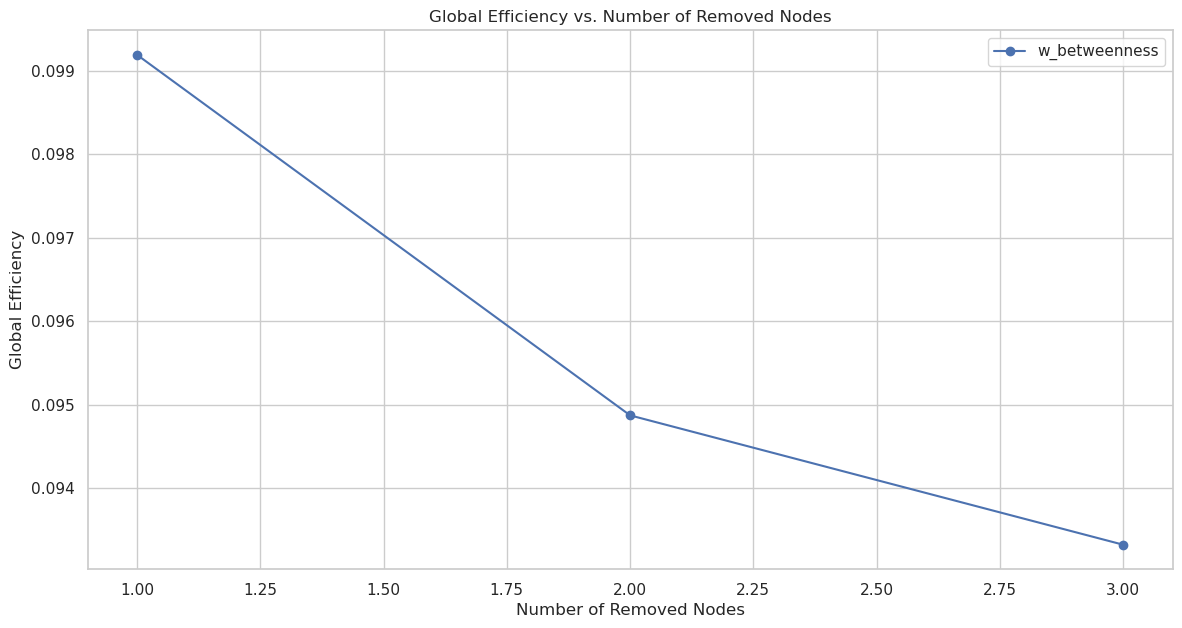

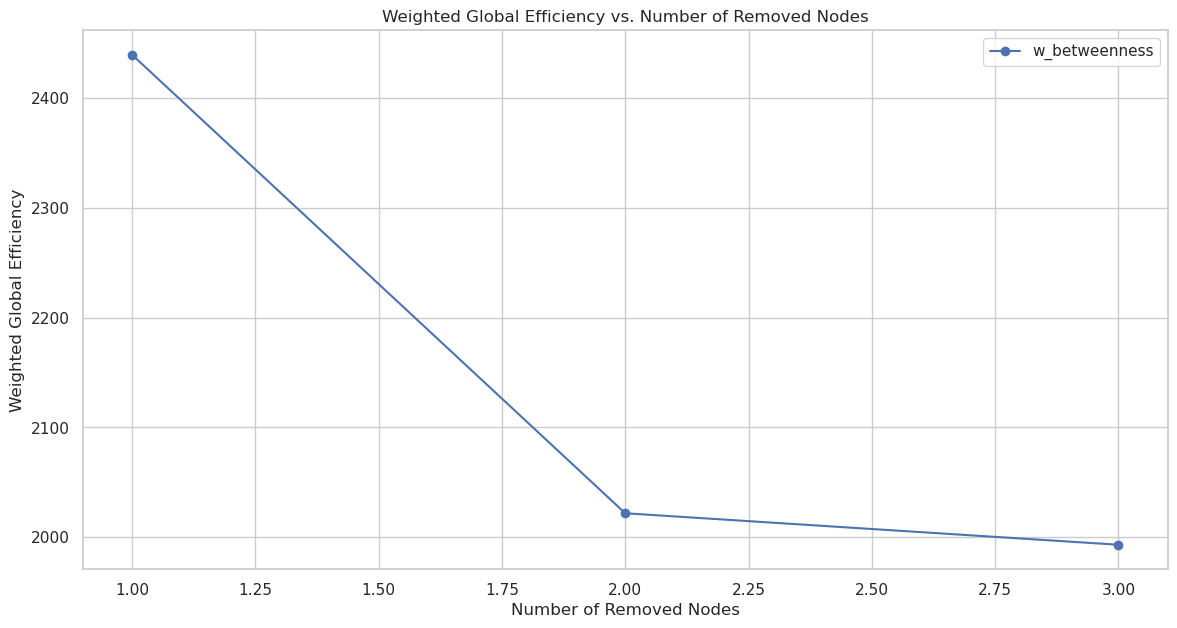

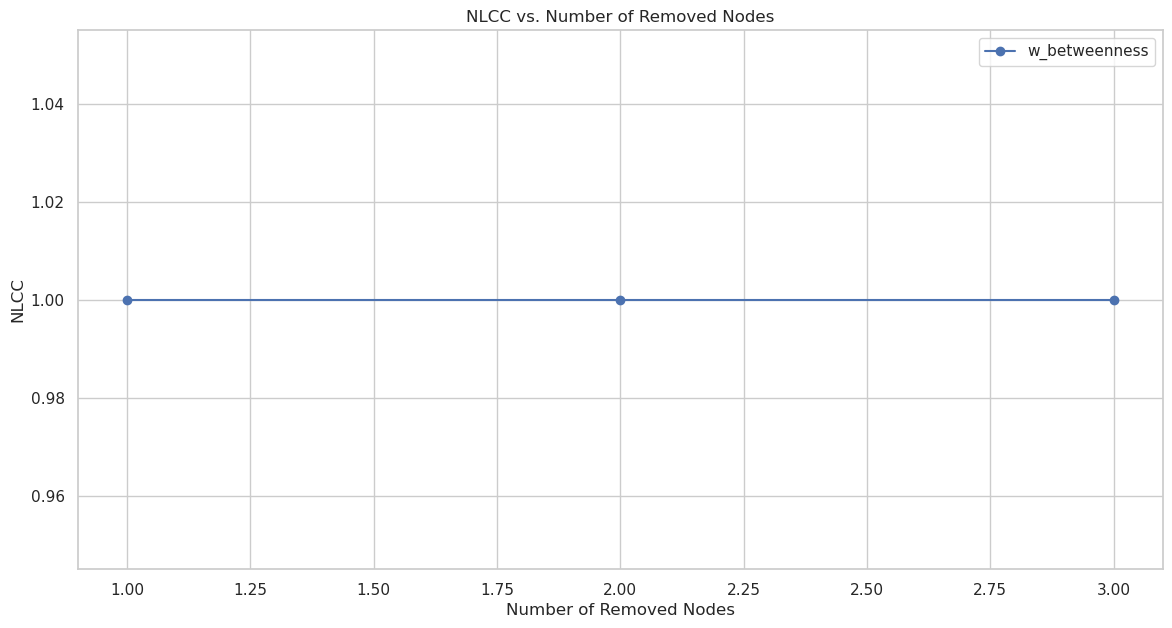

In [112]:
# Global efficiency.
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the global efficiency curve.
for entry in results_a_w:
    plt.plot(range(1, 4), entry['efficiency'], '-o', label=entry['measure'])

plt.title('Global Efficiency vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('Global Efficiency')
plt.legend()
plt.show()

# Weighted Global efficiency.
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the weighted global efficiency curve.
for entry in results_a_w:
    plt.plot(range(1, 4), entry['w_efficiency'], '-o', label=entry['measure'])

plt.title('Weighted Global Efficiency vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('Weighted Global Efficiency')
plt.legend()
plt.show()

# NLCC
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the NLCC curve.
for entry in results_a_w:
    plt.plot(range(1, 4), entry['nlcc'], '-o', label=entry['measure'])

plt.title('NLCC vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('NLCC')
plt.legend()
plt.show()

#### B) Sequential removal

In [113]:
# Add NetworkX's centrality calculation function to the dictionary.
w_centrality_functions = {
    'w_betweenness': lambda G: nx.betweenness_centrality(G, weight='reciprocal_flow'),
    # 'closeness': lambda G: nx.closeness_centrality(G, distance='reciprocal_flow'),
    # 'eigenvector': lambda G: nx.eigenvector_centrality(G, weight='flows', max_iter=1000, tol=1e-6)
}

# Data structure to store results.
results_b_w = []

In [114]:
# for measure in w_centrality_functions.keys():
#     G_temp = G.copy()
#     efficiency = []
#     nlcc = []
#     w_efficiency = []
    
#     # Perform node deletion 10 times.
#     for i in range(10):
#         # Recalculate the centrality of the current graph.
#         current_centrality = w_centrality_functions[measure](G_temp)
        
#         # Find the node with the highest centrality.
#         max_node = max(current_centrality, key=current_centrality.get)
        
#         # Delete the node.
#         G_temp.remove_node(max_node)
        
#         # Calculate global efficiency and NLCC and add to list.
#         efficiency.append(nx.global_efficiency(G_temp))
#         nlcc.append(calculate_nlcc(G_temp))
#         w_efficiency.append(weighted_global_efficiency(G_temp))
        
#     # Add results to results list.
#     results_b_w.append({
#         'measure': measure,
#         'efficiency': efficiency,
#         'nlcc': nlcc,
#         'w_efficiency': w_efficiency
#     })

#     # plot_result_network(G_temp, measure)
#     plot_result_network_cc(G_temp, measure)

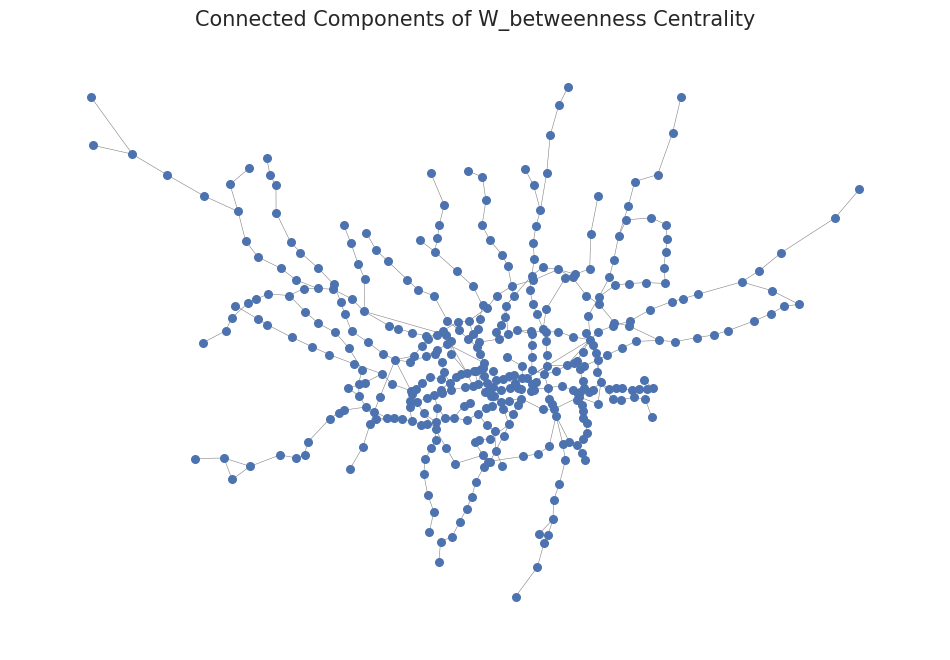

In [115]:
results_b_w = []
removed_node_details = {}

for measure in w_centrality_functions.keys():
    G_temp = G.copy()
    efficiency = []
    nlcc = []
    w_efficiency = []
    removed_nodes = []
    
    # Perform node deletion 10 times.
    for i in range(3):
        # Recalculate the centrality of the current graph.
        current_centrality = w_centrality_functions[measure](G_temp)
        
        # Find the node with the highest centrality.
        max_node = max(current_centrality, key=current_centrality.get)
        
        # Record the node and its centrality before deletion
        node_detail = (max_node, current_centrality[max_node])
        removed_nodes.append(node_detail)
        
        # Optionally, add to global dict for independent access
        if measure not in removed_node_details:
            removed_node_details[measure] = []
        removed_node_details[measure].append(node_detail)
        
        # Delete the node.
        G_temp.remove_node(max_node)
        
        # Calculate global efficiency and NLCC and add to list.
        efficiency.append(nx.global_efficiency(G_temp))
        nlcc.append(calculate_nlcc(G_temp))
        w_efficiency.append(weighted_global_efficiency(G_temp))
        
    # Add results to results list.
    results_b_w.append({
        'measure': measure,
        'efficiency': efficiency,
        'nlcc': nlcc,
        'w_efficiency': w_efficiency,
    })

    # plot_result_network(G_temp, measure)
    plot_result_network_cc(G_temp, measure)

In [116]:
removed_node_details

{'w_betweenness': [('Green Park', 0.5776566416040101),
  ('Bank and Monument', 0.6488835153209658),
  ("King's Cross St. Pancras", 0.517309469260661)]}

In [117]:
removed_node = pd.DataFrame(removed_node_details['w_betweenness'], columns=['Station', 'Centrality'])
removed_node.to_csv("removed_node.csv", index=False)

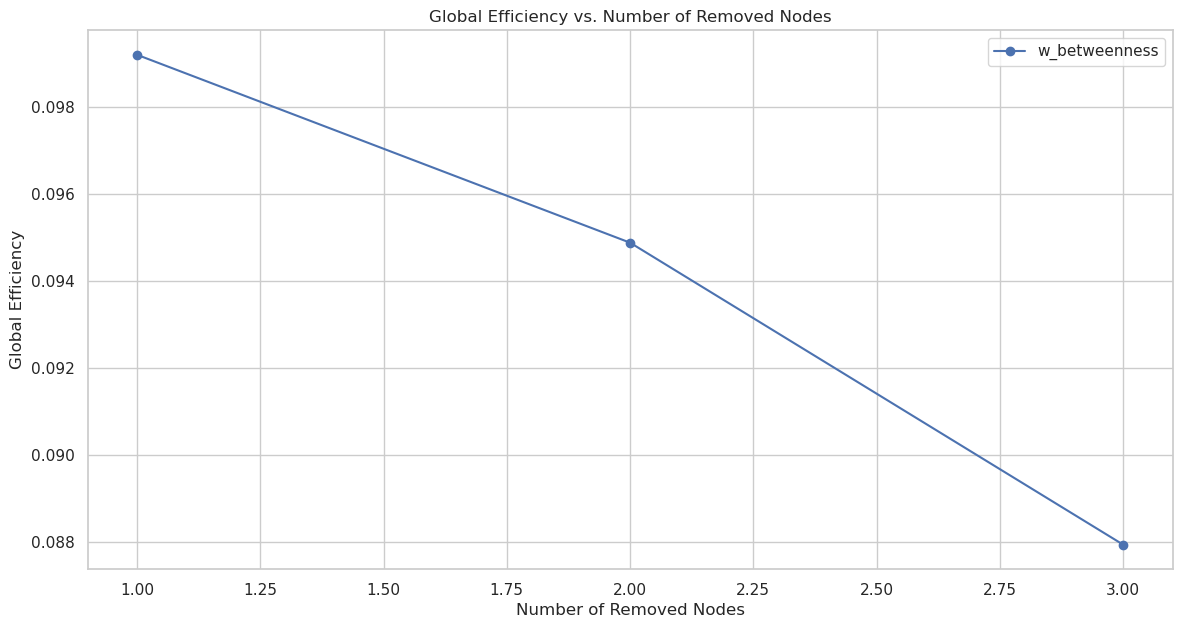

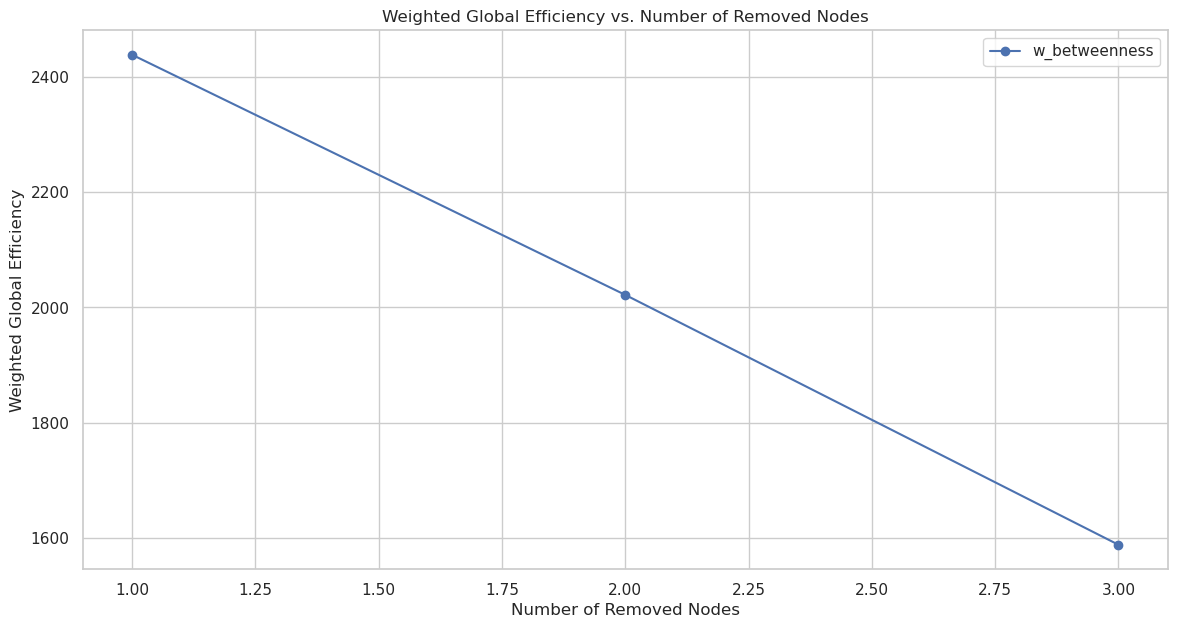

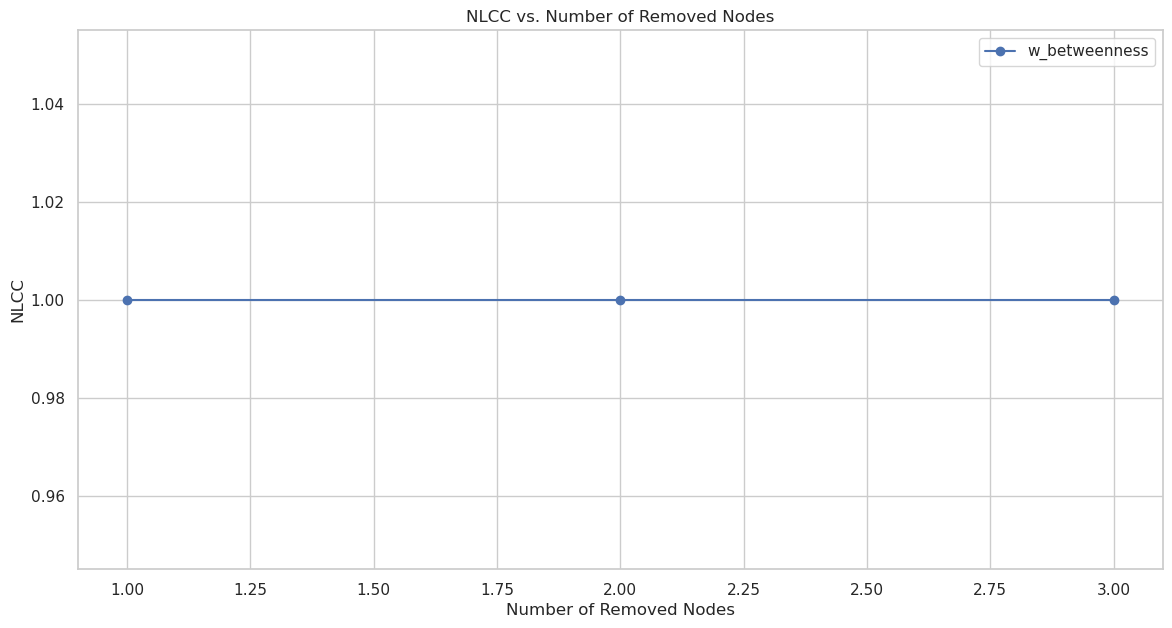

In [118]:
# Global efficiency.
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the global efficiency curve.
for entry in results_b_w:
    plt.plot(range(1, 4), entry['efficiency'], '-o', label=entry['measure'])

plt.title('Global Efficiency vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('Global Efficiency')
plt.legend()
plt.show()

# Weighted Global efficiency.
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the weighted global efficiency curve.
for entry in results_b_w:
    plt.plot(range(1, 4), entry['w_efficiency'], '-o', label=entry['measure'])

plt.title('Weighted Global Efficiency vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('Weighted Global Efficiency')
plt.legend()
plt.show()

# NLCC
plt.figure(figsize=(14, 7))

# For each centrality measure, plot the NLCC curve.
for entry in results_b_w:
    plt.plot(range(1, 4), entry['nlcc'], '-o', label=entry['measure'])

plt.title('NLCC vs. Number of Removed Nodes')
plt.xlabel('Number of Removed Nodes')
plt.ylabel('NLCC')
plt.legend()
plt.show()

In [121]:
# Function used to graph a measure.
def plot_measure_w(results_a, results_b, measure, title):
    plt.figure(figsize=(4, 4))

    # Plot the results of results_a.
    for idx, entry in enumerate(results_a):
        plt.plot(range(1, 4), entry[measure], '-o', label=f'{entry["measure"]} (a)', color=gradients_a[idx])

    # Plot the results of results_b.
    for idx, entry in enumerate(results_b):
        plt.plot(range(1, 4), entry[measure], '-o', label=f'{entry["measure"]} (b)', color=gradients_b[idx])

    plt.title(title)
    plt.xlabel('Number of Removed Nodes')
    plt.ylabel(measure.capitalize().replace('_', ' '))
    plt.legend()
    plt.grid(True)
    plt.show()

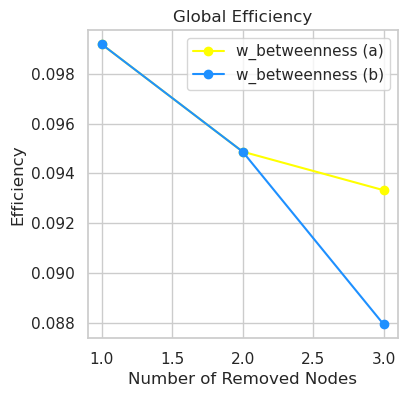

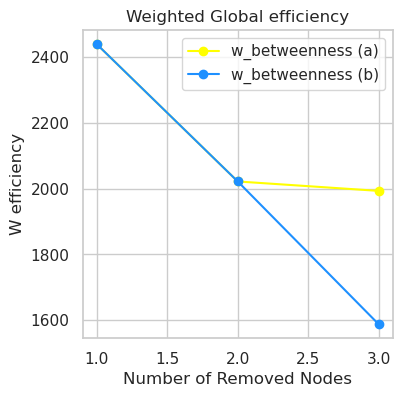

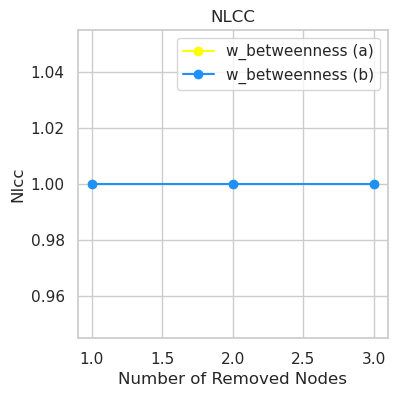

In [122]:
# Global efficiency.
plot_measure_w(results_a_w, results_b_w, 'efficiency', 'Global Efficiency')

# Weighted Global efficiency.
plot_measure_w(results_a_w, results_b_w, 'w_efficiency', 'Weighted Global efficiency')

# NLCC.
plot_measure_w(results_a_w, results_b_w, 'nlcc', 'NLCC')